# Evaluate UMLS

**Method Summary: Evaluating UMLS Code Extraction Accuracy**  
This notebook evaluates the accuracy of extracting Unified Medical Language System (UMLS) codes for patient diagnoses reported in biomedical research papers. The core process involves comparing UMLS codes generated by automated methods against manually annotated reference codes.

1. **Data Preparation:**  
   * We started with a dataset (combined\_pd.csv) containing annotations of participant demographics extracted from research papers. This dataset includes manually assigned UMLS codes (umls column) corresponding to the reported patient diagnoses. Some entries also contain umls\_posthoc codes, which were added after the initial annotation to refine or correct the ground truth.  
   * The data was filtered to include only entries pertaining to 'patients' and where a UMLS annotation exists. Key fields like PMCID, diagnosis text, and annotated UMLS codes were retained.  
2. **Loading Automated Predictions:**  
   * We loaded multiple sets of automated UMLS code predictions. These predictions were generated previously by applying the scispacy library's UMLS extractor to diagnosis strings.  
   * These diagnosis strings themselves were originally extracted using various methods, differing by:  
     * **Text Source:** Markdown (md) or HTML (html) conversion of the original paper.  
     * **Processing:** Full text (chunk=False) vs. chunked text (chunk=True) processing during the initial demographic extraction phase.  
     * **Model:** Different large language models (e.g., gpt-4o-2024-05-13, gpt-4o-mini-2024-07-18).  
     * **Prompt:** Different prompting strategies used for the initial demographic extraction (e.g., demographics-zeroshot, demographics-fewshot, demographics-zeroshot-ftstrict).  
   * Metadata describing the specific method used for each prediction set (source, chunking, model, prompt) was extracted from the filenames and stored.  
3. **Matching Predictions to Annotations:**  
   * For each prediction set, we matched the predicted UMLS codes (umls\_cui) against the manually annotated reference codes (umls and umls\_posthoc) for each paper (identified by pmcid).  
   * The matching process worked as follows for each paper:  
     * It iterated through each *annotated* diagnosis group.  
     * It attempted to find a *predicted* UMLS code that matched the *annotated* umls code(s).  
     * If no match was found, it attempted to find a match against the *annotated* umls\_posthoc code(s).  
     * Crucially, matching was done **without replacement** within each paper: once a predicted group (identified by group\_ix) was matched to an annotated group, it could not be matched to another annotated group in the same paper. This ensures a one-to-one mapping where possible.  
     * If multiple predicted codes matched a single annotation, the one with the highest confidence score (umls\_prob) was chosen.  
     * The outcome (match found \= 1, no match \= 0), whether the match involved a post-hoc code, the probability of the match, and the predicted diagnosis text were recorded. 
     * NOTE: `umls_posthoc` was added because often upon manual review it was clear that the prediction was correct, but did not match an existing annotation, so I added it afterward as a correct option. 
4. **Accuracy Calculation and Analysis:**  
   * Results from all prediction sets were combined.  
   * An "a priori" match metric was calculated, counting only matches to the original umls codes (excluding post-hoc matches).  
   * Summary statistics (total matches, mean accuracy) were calculated for both overall matches and a priori matches, grouped by the different extraction methods (source, chunking, model, prompt).  
   * The results were analyzed to compare the performance of different methods, examining overall accuracy, failure rates, and specific examples of mismatches and discrepancies between methods.

The goal was to determine which combination of text source, processing strategy, model, and prompt resulted in the most accurate automated UMLS code extraction when compared to manual annotations.  

In [1]:
import pandas as pd
from pathlib import Path

# Load the combined annotations CSV file into a pandas DataFrame.
# This file contains manually annotated demographic data, including UMLS codes.
annotations = pd.read_csv(f'../annotations/combined_pd.csv')

# Filter the DataFrame to keep only rows where 'group_name' is 'patients'.
# We are interested in evaluating UMLS codes associated with patient groups.
patients = annotations[annotations.group_name == 'patients']

# Further filter to keep only rows where the 'umls' column is not empty (not null).
# We need the manually annotated UMLS codes as the ground truth for comparison.
patients = patients[patients.umls.notnull()]

# Define the list of columns we want to keep for the anal   ysis.
fields_keep = ['pmcid', 'group_name', 'subgroup_name', 'count', 'umls', 'umls_posthoc', 'diagnosis']

# Select only the specified columns.
patients = patients[fields_keep]
outputs = Path('../outputs/demographics/extractions')

In [2]:
# Display rows where post-hoc UMLS codes were added (for informational purposes)
annotations[annotations.umls_posthoc.notnull()]

,Unnamed: 0,group_name,subgroup_name,project_name,annotator_name,pmcid,umls,umls_posthoc,diagnosis,count,male count,age mean,female count,age minimum,age maximum,age median
8,109,patients,amci,participant_demographics,Jerome_Dockes,7838677,C5394908,C1270972,amnestic mild cognitive impairment,11,4.0,NaN,7.0,65.0,81.0,NaN
12,79,patients,ais,participant_demographics,Jerome_Dockes,8785614,C5680049,C0948008,arterial ischemic stroke,26,NaN,NaN,NaN,NaN,NaN,NaN
34,372,patients,_,participant_demographics,Jerome_Dockes,4048172,C0740418,C0150055,Chronic Back Pain,13,4.0,51.8,9.0,43.0,65.0,NaN
35,405,patients,_,participant_demographics,Jerome_Dockes,7416060,C4518790,C0024809,Chronic cannabis users,54,NaN,NaN,NaN,NaN,NaN,NaN
37,64,patients,_,participant_demographics,Jerome_Dockes,4473263,C0586325,C0038454,chronic left-hemisphere stroke,32,27.0,62.0,5.0,NaN,NaN,NaN
39,265,patients,_,participant_demographics,Jerome_Dockes,3742334,C4518790,C0024809,chronic marijuana use,10,8.0,NaN,2.0,NaN,NaN,NaN
40,346,patients,_,participant_demographics,Jerome_Dockes,6585311,C2711916,C0018989,chronic post-stroke hemiparesis,10,6.0,66.7,4.0,NaN,NaN,NaN
43,39,patients,_,participant_demographics,Jerome_Dockes,8459240,C4237066,C4763868,cocaine use disorder,55,27.0,NaN,28.0,NaN,NaN,NaN
45,341,patients,_,participant_demographics,Jerome_Dockes,5371603,C0011053,C1547302,deafness,14,3.0,25.0,11.0,18.0,33.0,NaN
48,411,patients,_,participant_demographics,Jerome_Dockes,4589842,"C2362914, C1269683, C0006012",C0344315,Depression,11,5.0,61.0,6.0,NaN,NaN,NaN


In [3]:
# Reset the index of the 'patients' DataFrame and add the old index as a column named 'index'.
# This is useful for referencing original rows later, especially when using .at for assignment.
patients = patients.reset_index()

# Initialize an empty list to store DataFrames loaded from prediction files.
all_predictions = []

# Loop through all files in the 'outputs' directory that contain 'umls' in their filename.
for pred in list(outputs.glob('*umls*')):
    # Parse the filename to extract metadata about the prediction run.
    md = pred.stem.split('_') # Split filename by underscore

    # Check if the filename indicates a 'chunked' processing approach.
    if md[0] == 'chunked':
        chunk = True          # Flag indicating chunked text processing was used
        prompt = md[1]        # Prompt type used for extraction
        model_name = md[2]    # Name of the LLM used
        source = 'md'         # Assume source is markdown for chunked (adjust if needed)
    else:
        # Assume non-chunked approach (full text)
        chunk = False         # Flag indicating full text processing was used
        source = md[1]        # Text source (e.g., 'md' or 'html')
        prompt = md[2]        # Prompt type used for extraction
        model_name = md[3]    # Name of the LLM used

    # Read the prediction CSV file into a DataFrame.
    pred_df = pd.read_csv(pred)

    # Add the extracted metadata as new columns to the prediction DataFrame.
    pred_df['chunk'] = chunk
    pred_df['source'] = source
    pred_df['prompt'] = prompt
    pred_df['model_name'] = model_name

    # Append the processed prediction DataFrame to the list.
    all_predictions.append(pred_df)



In [4]:
# For each PMCID, get the best match for each UMLS code, without replacement (i.e. only one match per UMLS code)
# If no match is found, then the UMLS code is not matched

def match_umls_codes(umls_predictions, annot_patients):
    """
    Matches predicted UMLS codes to annotated UMLS codes for each document (PMCID).

    Args:
        umls_predicitons (pd.DataFrame): DataFrame containing UMLS predictions for one method.
                                         Must include 'pmcid', 'umls_cui', 'umls_prob', 'group_ix',
                                         'diagnosis', 'source', 'prompt', 'model_name', 'chunk'.
        annot_patients (pd.DataFrame): DataFrame containing annotated patient groups.
                                       Must include 'pmcid', 'umls', 'umls_posthoc'.

    Returns:
        pd.DataFrame: A copy of annot_patients augmented with match results ('umls_match',
                      'umls_posthoc_match', 'umls_prob', 'diagnosis_pred') and metadata
                      from the predictions DataFrame.
    """
    annot_patients = annot_patients.copy()

    # Group annotations by document (PMCID) and process each document individually.
    for pmcid, group in annot_patients.groupby('pmcid'):
        # Get the UMLS predictions specific to the current document.
        doc_preds = umls_predictions[umls_predictions.pmcid == pmcid]

        if len(doc_preds) == 0:
            continue

        used_group_ixs = []
        # Iterate through each annotated patient group within the current document.        
        for row in group.itertuples():

            # Skip if no UMLS codes
            if pd.isnull(row.umls):
                continue

            correct = [c.strip() for c in row.umls.split(', ')]
            if pd.isnull(row.umls_posthoc):
                posthoc_correct = []
            else:
                # Compute "posthoc" matches (i.e. UMLS codes added after the initial annotation)
                posthoc_correct = [c.strip() for c in row.umls_posthoc.split(', ')]
            
            # 1. Try matching against ORIGINAL annotated UMLS codes first.
                        # Find predictions where:
                        #   a) The predicted UMLS CUI is in the 'correct' list.
                        #   b) The prediction's group index ('group_ix') has NOT been used yet.
            matches = doc_preds[(doc_preds['umls_cui'].isin(correct)) & (doc_preds['group_ix'].isin(used_group_ixs) == False)]
            is_posthoc = False

            # 2. If no match found with original codes, try matching against POST-HOC codes.
            if len(matches) == 0:
                # If no match, try with posthoc
                matches = doc_preds[(doc_preds['umls_cui'].isin(posthoc_correct)) & (doc_preds['group_ix'].isin(used_group_ixs) == False)]
                is_posthoc = True

            # --- Record Match Result ---
            if len(matches) > 0:
                # Take the best match
                m =  matches[matches['umls_prob'] == matches['umls_prob'].max()].iloc[0]
                # Add the group index to the used list
                used_group_ixs.append(m['group_ix'])
                
                annot_patients.at[row.Index, 'umls_match'] = 1
                annot_patients.at[row.Index, 'umls_posthoc_match'] = is_posthoc

                annot_patients.at[row.Index, 'umls_prob'] = m['umls_prob']
                annot_patients.at[row.Index, 'diagnosis_pred'] = m['diagnosis']
            else:
                annot_patients.at[row.Index, 'umls_match'] = 0

    # Add metadata from the prediction run to the results DataFrame.
    # Assumes all predictions in umls_predicitons come from the same run.
    annot_patients['source'] = umls_predictions['source'].iloc[0]
    annot_patients['prompt'] = umls_predictions['prompt'].iloc[0]
    annot_patients['model_name'] = umls_predictions['model_name'].iloc[0]
    annot_patients['chunk'] = umls_predictions['chunk'].iloc[0]

    return annot_patients

#### Apply Matching and Summarize Results

In [5]:
# For each prediction file, get the best match for each UMLS code, without replacement (i.e. only one match per UMLS code)
matches = []
for pred_df in all_predictions:
    matches.append(match_umls_codes(pred_df, patients))

matches = pd.concat(matches)

# Create a new column 'umls_match_apriori' to specifically track matches
# made ONLY with the original annotated UMLS codes (i.e., excluding post-hoc matches).
matches['umls_match_apriori'] = matches['umls_match']
# Set 'umls_match_apriori' to 0 where a match occurred BUT it was a post-hoc match.
matches.loc[(matches.umls_match == 1) & (matches.umls_posthoc_match == True), 'umls_match_apriori'] = 0

# Calculate summary statistics by grouping the results by the experimental conditions.
summary = matches.groupby(['source', 'prompt', 'model_name', 'chunk']).agg(
    match_n=('umls_match','sum'), 
    match_mean_accuracy= ('umls_match','mean'),
    match_n_aprior=('umls_match_apriori','sum'),
    match_mean_accuracy_aprior=('umls_match_apriori','mean'),
    mean_umls_prob=('umls_prob','mean')).reset_index()

In [6]:
# Sort the summary table for better readability, primarily by chunk status and source.
summary.sort_values(['match_mean_accuracy'])

,source,prompt,model_name,chunk,match_n,match_mean_accuracy,match_n_aprior,match_mean_accuracy_aprior,mean_umls_prob
6,md,demographics-zeroshot,gpt-3.5-turbo-0125,True,9.0,0.473684,9.0,0.473684,0.873188
4,md,demographics-zeroshot,firefunction-v1,True,183.0,0.685393,158.0,0.591760,0.877591
7,md,demographics-zeroshot,gpt-3.5-turbo-0613,True,96.0,0.768000,82.0,0.656000,0.899756
0,html,demographics-zeroshot,gpt-4o-mini-2024-07-18,False,56.0,0.800000,46.0,0.657143,0.915550
10,md,demographics-zeroshot,gpt-4o-2024-05-13,False,116.0,0.805556,98.0,0.680556,0.904426
14,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False,116.0,0.811189,98.0,0.685315,0.892862
8,md,demographics-zeroshot,gpt-3.5-turbo-1106,True,144.0,0.822857,125.0,0.714286,0.886297
2,md,demographics-zeroshot,claude-3.5-sonnet,False,118.0,0.825175,102.0,0.713287,0.890588
15,md,demographics-zeroshot-ftstrict,gpt-4o-mini-2024-07-18,False,119.0,0.832168,102.0,0.713287,0.870197
5,md,demographics-zeroshot,firefunction-v2,True,223.0,0.844697,190.0,0.719697,0.912051


In [18]:
mean_umls

,source,prompt,model_name,chunk,match_n,match_mean_accuracy,match_n_aprior,match_mean_accuracy_aprior,mean_umls_prob,umls_match,subset
2,md,demographics-zeroshot,claude-3.5-sonnet,False,118.0,0.825175,102.0,0.713287,0.890588,82.517483,Full Text
10,md,demographics-zeroshot,gpt-4o-2024-05-13,False,116.0,0.805556,98.0,0.680556,0.904426,80.555556,Full Text
12,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,False,121.0,0.846154,100.0,0.699301,0.891522,84.615385,Full Text


In [21]:
import seaborn.objects as so
import seaborn as sns

model_order = ['firefunction-v2', 'gpt-3.5-turbo-1106', 'gpt-4-0125-preview','gpt-4o-2024-05-13', 'gpt-4o-mini-2024-07-18', 'claude-3.5-sonnet']
summary['model_name'] = pd.Categorical(summary['model_name'], categories=model_order, ordered=True)

# Subset to only look at prompt === 'demographics-zeroshot', chunk == False and source =='md'ArithmeticError
mean_umls = summary[(summary.prompt == 'demographics-zeroshot') & (summary.source == 'md')].copy()
mean_umls['umls_match'] = mean_umls['match_mean_accuracy'] * 100
mean_umls['subset'] = mean_umls['chunk'].replace({True: 'Chunked', False: 'Full Text'})


p = (
        so.Plot(mean_umls, x='model_name', y='match_mean_accuracy',
                        marker='source',  color='subset')
        .add(so.Dot(pointsize=15, edgecolor="white"), so.Jitter(.3))
    ).theme(
        {**sns.axes_style("ticks"), 'axes.spines.right': False, 'axes.spines.top': False}
    ).label(
        x='Model Name', y='UMLS Match Rate (%)', xtick_rotation=90
    ).layout(size=(7, 7)
    ).limit(y=(0, 1)
    ).plot()

# Rotate x-axis labels
p._figure.axes[0].xaxis.set_tick_params(rotation=10)
p._figure.legends[0].set_bbox_to_anchor((1, 0.5))
p.show()
# p.save('../outputs/figures/umls_match_rate.png', dpi=300)

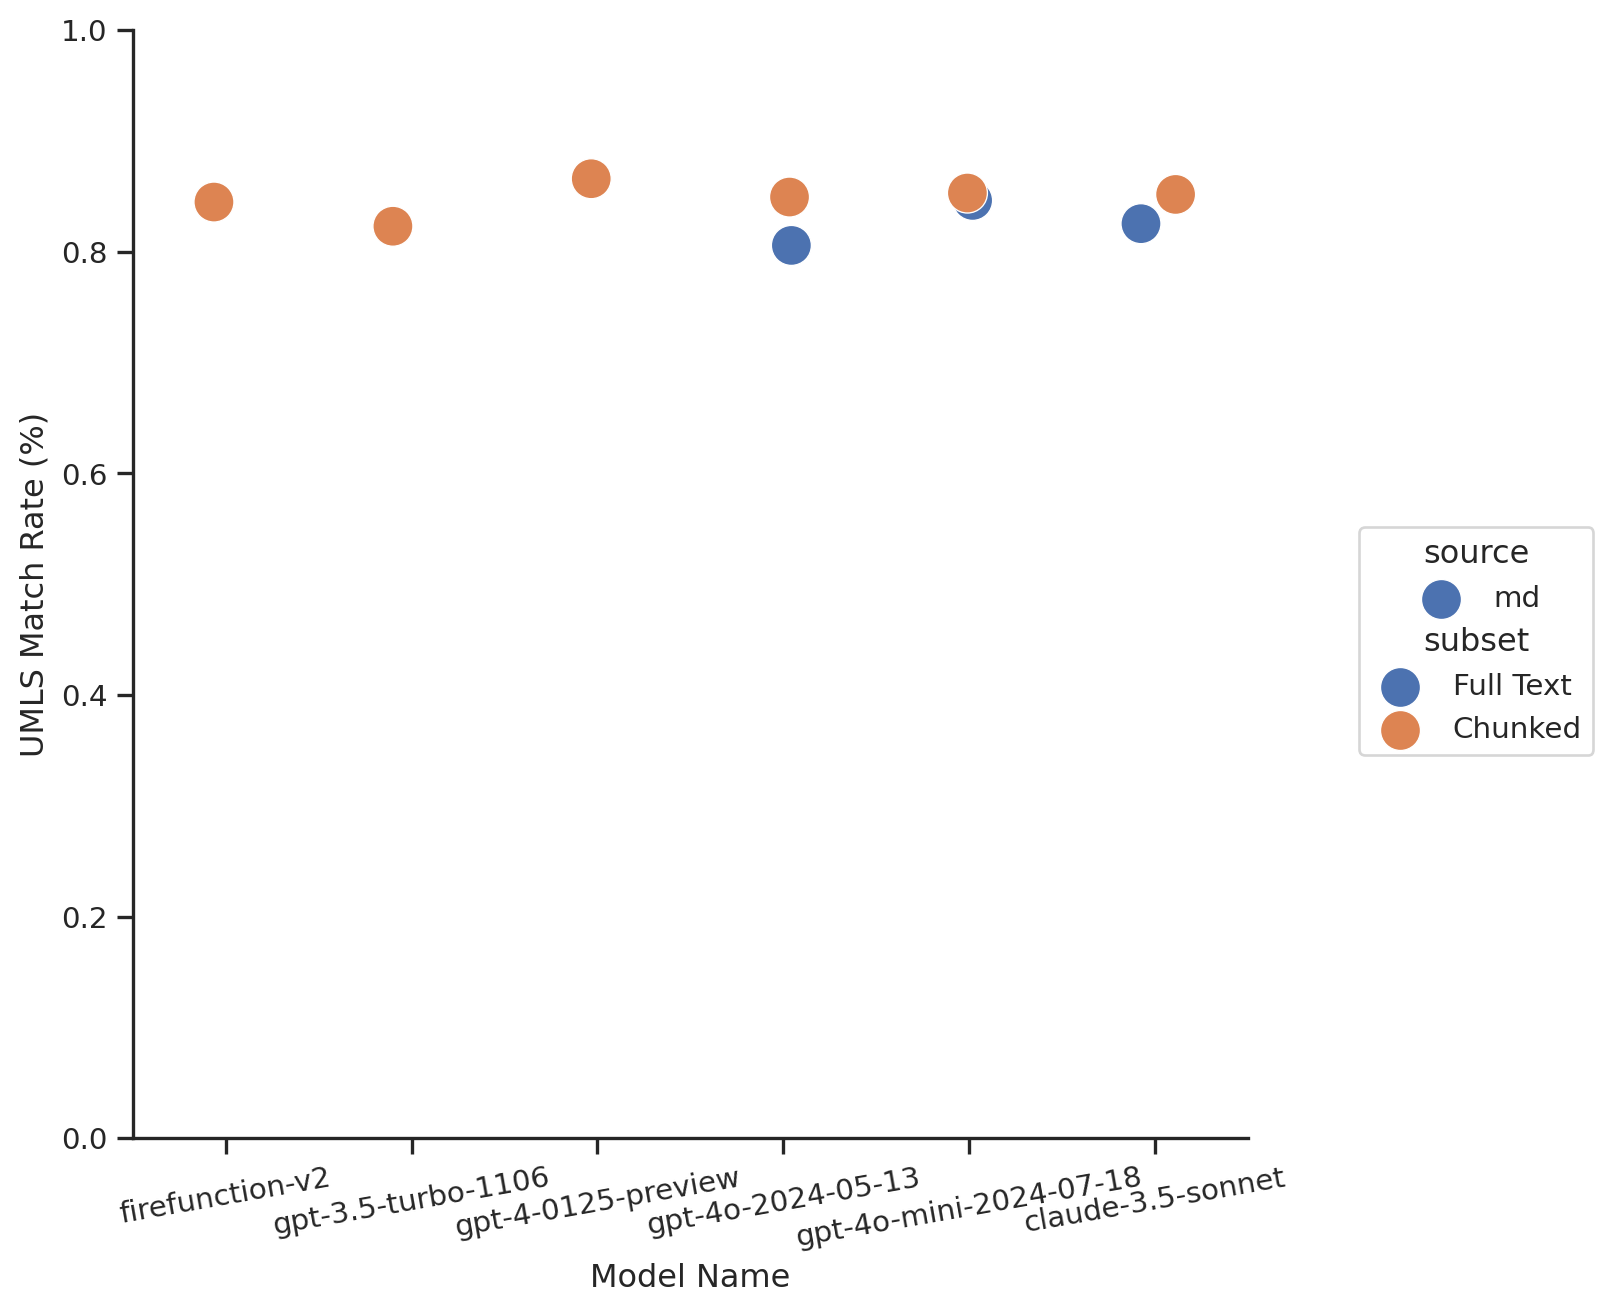

In [22]:
p

#### Analysis of Mismatches and Discordance

 Qualitative summary notes based on the 'summary' table (provided by user):
 - HTML extraction performed poorly, often failing to predict diagnoses.
 - Markdown extraction methods were generally reasonable.
 - Chunked approaches sometimes missed predictions but had higher accuracy on successful ones.
 - Full text extraction with GPT-4o mini yielded the highest total number of matches.


## Detailed Look at Incorrect Examples

For the most promising model (GPT4o mini with basic full text MD extraction), let's look at PMIDS where at least one mismatch occured.


Notes: In many cases a mismatch could still be considered correct because the UMLS code was different but it described the same disease.

Also, sometimes it was impossible to match due to difference in groups detected vs annotated (but still reasonable "correct" annotation)

Finally, often the diagnosis field was subjectively correct, even if not identical (and mismatch on UMLS code).

In [8]:
# Select a promising configuration for closer examination
# (Example uses GPT-4o-mini, full text, markdown, zeroshot prompt).
# Note: The index [4] corresponds to the 5th element in `all_predictions`.
#       This index might need adjustment if the order of `all_predictions` changes.

subset = matches[(matches.model_name == 'gpt-4o-2024-05-13') & (matches.chunk == True) & (matches.prompt == 'demographics-zeroshot') & (matches.source == 'md')]

# Find the PMCIDs where at least one annotated UMLS code was NOT matched (umls_match == 0)
# for the selected configuration.
mismatch_pmcids = subset[subset.umls_match == 0].pmcid.unique() # PMICS with at least one mismatch

preds = all_predictions[6] # Get the predictions for the model of interest (this one matches the subset)
preds = preds.sort_values('umls_prob', ascending=False).groupby('group_ix').first().reset_index() # Keep only the highest probability for each prediction group

In [9]:
# Display the mismatched PMCID and the corresponding annotations and predictions.
for pmcid in mismatch_pmcids:
    print(pmcid)
    print("Annotation:")
    display(subset[subset.pmcid == pmcid][['count', 'diagnosis', 'umls']])
    print("Prediction:")
    display(preds[preds.pmcid == pmcid][['count', 'diagnosis', 'umls_cui', 'umls_name', 'umls_prob']])

8785614
Annotation:


,count,diagnosis,umls
12,26,arterial ischemic stroke,C5680049
100,26,periventricular venous infarction,C1300444
12,26,arterial ischemic stroke,C5680049
100,26,periventricular venous infarction,C1300444


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
100,0.0,unilateral perinatal stroke,C0205092,UNILATERAL,0.623875


5460048
Annotation:


,count,diagnosis,umls
35,75,chronic dieters,C5687959
35,75,chronic dieters,C5687959


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
182,75.0,chronic dieters,C0205191,chronic,0.701405


4473263
Annotation:


,count,diagnosis,umls
36,32,chronic left-hemisphere stroke,C0586325
36,32,chronic left-hemisphere stroke,C0586325


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob


6220927
Annotation:


,count,diagnosis,umls
43,12,cockroach phobia,C0236801
43,12,cockroach phobia,C0236801


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
112,12.0,cockroach phobia,C0009208,Cockroach,0.731772


5371603
Annotation:


,count,diagnosis,umls
44,14,deafness,C0011053
44,14,deafness,C0011053


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
56,14.0,congenitally profoundly deaf,C0009678,congenital,0.551497


6509414
Annotation:


,count,diagnosis,umls
59,26,hearing loss,C3887873
59,26,hearing loss,C3887873


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
141,13.0,hearing-impaired,C1550444,Hearing impaired,0.837733
142,13.0,hearing-impaired,C1550444,Hearing impaired,0.837733


4990879
Annotation:


,count,diagnosis,umls
61,40,heroin addiction,C0019337
61,40,heroin addiction,C0019337


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
23,40.0,heroin relapser and non-relapser,C0205336,relapse,0.667092


5686883
Annotation:


,count,diagnosis,umls
62,10,idiopathic musculoskeletal pain,C0026858
62,10,idiopathic musculoskeletal pain,C0026858


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
19,10.0,juvenile fibromyalgia,C3896653,Juvenile Primary Fibromyalgia Syndrome,0.822386


4174863
Annotation:


,count,diagnosis,umls
65,157,incarcerated,C0392751
65,157,incarcerated,C0392751


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
62,157.0,"Substance use disorders, major depression",C1269683,"Depressive Disorders, Major",0.702496


5903407
Annotation:


,count,diagnosis,umls
72,27,left hemisphere infarcts,"C0751010, C0586325"
72,27,left hemisphere infarcts,"C0751010, C0586325"


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
98,27.0,left hemisphere infarcts,C0228176,Left Brain Hemisphere,0.691714


7838677
Annotation:


,count,diagnosis,umls
8,11,amnestic mild cognitive impairment,C5394908
83,6,mild Alzheimer's dementia,C0002395
8,11,amnestic mild cognitive impairment,C5394908
83,6,mild Alzheimer's dementia,C0002395


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
63,11.0,amnestic mild cognitive impairment,C1270972,Mild cognitive impairment,0.837283
64,6.0,mild Alzheimer's dementia,C0002395,Alzheimer's Dementia,0.855839


9230060
Annotation:


,count,diagnosis,umls
91,20,offenders,C0699726
91,20,offenders,C0699726


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
145,6.0,affective violence,C0013987,affective state,0.616255
146,7.0,predatory violence,C0042693,violence,0.676785
147,7.0,non-violent crime,C0042693,Violent Crime,0.785863


6678781
Annotation:


,count,diagnosis,umls
99,61,Pedophilic Child Sexual Offenders,C0524400
99,61,Pedophilic Child Sexual Offenders,C0524400


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
158,23.0,non-convicted child sexual offenders,C0699726,Offenders,0.509654
159,38.0,convicted child sexual offenders,C0699726,Offenders,0.543668


2494616
Annotation:


,count,diagnosis,umls
101,13,phantom limb pain,C4048296
101,13,phantom limb pain,C4048296


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
45,13.0,"unilateral, upper limb amputation and phantom ...",C0031315,PHANTOM LIMB PAIN,0.667169


7518235
Annotation:


,count,diagnosis,umls
103,24,post-prandial distress subtype functional dysp...,"C0267167, C1269683"
104,24,post-prandial distress subtype functional dysp...,C0267167
103,24,post-prandial distress subtype functional dysp...,"C0267167, C1269683"
104,24,post-prandial distress subtype functional dysp...,C0267167


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
84,24.0,FD-PDS-Major Depressive Disorder,C0041696,Major Depressive Disorder,0.815032


8550949
Annotation:


,count,diagnosis,umls
119,31,schizophrenia,C0036341
119,31,schizophrenia,C0036341


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
5,31.0,drug-nave/free first episode psychosis,C4085940,Age at First Episode,0.505314


5104469
Annotation:


,count,diagnosis,umls
123,21,Severe Childhood Abuse,C5828513
123,21,Severe Childhood Abuse,C5828513


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
139,21.0,history of childhood abuse,C0262926,History of,0.614514


6699415
Annotation:


,count,diagnosis,umls
128,5,supratentorial gliomas,C0017638
128,5,supratentorial gliomas,C0017638


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
181,5.0,patients,C0030705,patients,0.98214


8933317
Annotation:


,count,diagnosis,umls
130,66,Temporal lobe epilepsy,C0014556
130,66,Temporal lobe epilepsy,C0014556


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
113,66.0,Temporal lobe epilepsy patients with unilatera...,C4749367,Mesial temporal lobe epilepsy with hippocampal...,0.80136


4215530
Annotation:


,count,diagnosis,umls
142,24,Very preterm birth\n,C3897192
142,24,Very preterm birth\n,C3897192


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
59,24.0,"VPT with no history of cerebral palsy, grade 3...",C4505184,Cerebral Intraventricular Haemorrhage,0.691623


5598991
Annotation:


,count,diagnosis,umls
52,58,early adult onset depression,C1269683
71,62,later adult onset depression,C1269683
52,58,early adult onset depression,C1269683
71,62,later adult onset depression,C1269683


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
38,147.0,Major depressive disorder,C1269683,Major Depressive Disorder,0.966161


5655292
Annotation:


,count,diagnosis,umls
96,18,Parkinson's disease with anxiety disorder,"C0030567, C0003469"
97,45,Parkinson's disease without anxiety disorder,C0030567
96,18,Parkinson's disease with anxiety disorder,"C0030567, C0003469"
97,45,Parkinson's disease without anxiety disorder,C0030567


Prediction:


,count,diagnosis,umls_cui,umls_name,umls_prob
131,65.0,idiopathic Parkinson's disease,C0030567,Idiopathic Parkinson's disease,0.970185


### Dischordant examples

Excluding HTML and few shot prompts

In [10]:

matches_ex = matches[matches.source != 'html']
matches_ex = matches_ex[matches_ex.prompt != 'demographics-fewshot']

all_predictions_ex = pd.concat(all_predictions)
all_predictions_ex = all_predictions_ex[all_predictions_ex.source != 'html']
all_predictions_ex = all_predictions_ex[all_predictions_ex.prompt != 'demographics-fewshot']

In [11]:
# Groupby pmcid and only show examples where umls_match is not the same for all rows

for pmcid, group in matches_ex.groupby('pmcid'):
    if len(group.umls_match.unique()) > 1:
        display(group[['pmcid', 'umls', 'umls_match', 'umls_prob', 'diagnosis', 'diagnosis_pred', 'source', 'prompt', 'model_name', 'chunk']])

,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
101,2494616,C4048296,NaN,NaN,phantom limb pain,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
101,2494616,C4048296,NaN,NaN,phantom limb pain,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
101,2494616,C4048296,0.0,NaN,phantom limb pain,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
101,2494616,C4048296,0.0,NaN,phantom limb pain,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
101,2494616,C4048296,1.0,0.979491,phantom limb pain,phantom limb pain,md,demographics-zeroshot,claude-3.5-sonnet,False
101,2494616,C4048296,0.0,NaN,phantom limb pain,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
101,2494616,C4048296,0.0,NaN,phantom limb pain,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
101,2494616,C4048296,0.0,NaN,phantom limb pain,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
101,2494616,C4048296,NaN,NaN,phantom limb pain,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
101,2494616,C4048296,1.0,0.979491,phantom limb pain,phantom limb pain,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
20,2648877,C1510586,NaN,NaN,Autism Spectrum Disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
20,2648877,C1510586,1.0,0.984577,Autism Spectrum Disorder,Autism Spectrum Disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
63,3045463,"C0030567, C0865475",1.0,0.970185,idiopathic Parkinson's Disease,idiopathic Parkinson's disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
63,3045463,"C0030567, C0865475",1.0,0.962995,idiopathic Parkinson's Disease,Parkinson's disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
63,3045463,"C0030567, C0865475",1.0,0.970185,idiopathic Parkinson's Disease,idiopathic Parkinson's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
63,3045463,"C0030567, C0865475",1.0,0.970185,idiopathic Parkinson's Disease,idiopathic Parkinson's disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
63,3045463,"C0030567, C0865475",1.0,0.962995,idiopathic Parkinson's Disease,Parkinson's disease,md,demographics-zeroshot,claude-3.5-sonnet,False
63,3045463,"C0030567, C0865475",1.0,0.970185,idiopathic Parkinson's Disease,idiopathic Parkinson's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
63,3045463,"C0030567, C0865475",1.0,0.970185,idiopathic Parkinson's Disease,idiopathic Parkinson's disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
63,3045463,"C0030567, C0865475",1.0,0.970185,idiopathic Parkinson's Disease,idiopathic Parkinson's Disease,md,demographics-zeroshot,claude-3.5-sonnet,True
63,3045463,"C0030567, C0865475",NaN,NaN,idiopathic Parkinson's Disease,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
63,3045463,"C0030567, C0865475",1.0,0.970185,idiopathic Parkinson's Disease,idiopathic Parkinson's disease,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,claude-3.5-sonnet,False
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,claude-3.5-sonnet,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-4-0125-preview,True
94,3182403,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
7,3423412,C0002395,1.0,0.934186,Alzheimer disease,Alzheimer disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
84,3423412,C1270972,1.0,0.972051,mild cognitive impairment,mild cognitive impairment,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
7,3423412,C0002395,NaN,NaN,Alzheimer disease,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
84,3423412,C1270972,NaN,NaN,mild cognitive impairment,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
7,3423412,C0002395,1.0,0.934186,Alzheimer disease,Alzheimer disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
84,3423412,C1270972,1.0,0.972051,mild cognitive impairment,mild cognitive impairment,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
7,3423412,C0002395,1.0,0.934186,Alzheimer disease,Alzheimer disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
84,3423412,C1270972,1.0,0.972051,mild cognitive impairment,mild cognitive impairment,md,demographics-zeroshot,gpt-4o-2024-05-13,True
7,3423412,C0002395,1.0,0.946372,Alzheimer disease,Alzheimer's disease,md,demographics-zeroshot,claude-3.5-sonnet,False
84,3423412,C1270972,1.0,0.972051,mild cognitive impairment,Mild Cognitive Impairment,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
9,3447931,C0002736,1.0,0.699703,amyotrophic lateral sclerosis,probable or definite sporadic amyotrophic late...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
9,3447931,C0002736,NaN,NaN,amyotrophic lateral sclerosis,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
9,3447931,C0002736,1.0,0.972338,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
9,3447931,C0002736,1.0,0.972338,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
9,3447931,C0002736,1.0,0.972338,amyotrophic lateral sclerosis,Amyotrophic Lateral Sclerosis,md,demographics-zeroshot,claude-3.5-sonnet,False
9,3447931,C0002736,1.0,0.972338,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
9,3447931,C0002736,1.0,0.972338,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
9,3447931,C0002736,1.0,0.699703,amyotrophic lateral sclerosis,probable or definite sporadic amyotrophic late...,md,demographics-zeroshot,claude-3.5-sonnet,True
9,3447931,C0002736,1.0,0.893150,amyotrophic lateral sclerosis,Amyotrophic Lateral Sclerosis (ALS),md,demographics-zeroshot,gpt-4-0125-preview,True
9,3447931,C0002736,1.0,0.972338,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,mal de debarquement syndrome,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
80,3510214,C1608983,1.0,0.791612,mal de debarquement syndrome,persistent mal de debarquement syndrome,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,mal de debarquement syndrome,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,mal de debarquement syndrome,md,demographics-zeroshot,gpt-4o-2024-05-13,True
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,Mal de Debarquement Syndrome,md,demographics-zeroshot,claude-3.5-sonnet,False
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,mal de debarquement syndrome,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,mal de debarquement syndrome,md,demographics-zeroshot,gpt-4o-2024-05-13,True
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,Mal de Debarquement Syndrome,md,demographics-zeroshot,claude-3.5-sonnet,True
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,mal de debarquement syndrome,md,demographics-zeroshot,gpt-4-0125-preview,True
80,3510214,C1608983,1.0,0.931032,mal de debarquement syndrome,mal de debarquement syndrome,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
1,3701149,C2936346,1.0,0.646657,22q11.2 Deletion Syndrome,adolescents with a 22q11.2 Deletion Syndrome,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
17,3701149,C0233762,1.0,0.661285,auditory hallucination,adolescents with transient auditory hallucinat...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
1,3701149,C2936346,1.0,0.646657,22q11.2 Deletion Syndrome,adolescents with a 22q11.2 Deletion Syndrome,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
17,3701149,C0233762,1.0,0.661285,auditory hallucination,adolescents with transient auditory hallucinat...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
1,3701149,C2936346,1.0,0.646657,22q11.2 Deletion Syndrome,adolescents with a 22q11.2 Deletion Syndrome,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
17,3701149,C0233762,1.0,0.661285,auditory hallucination,adolescents with transient auditory hallucinat...,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
1,3701149,C2936346,1.0,0.842059,22q11.2 Deletion Syndrome,22q11.2 Deletion Syndrome,md,demographics-zeroshot,gpt-4o-2024-05-13,True
17,3701149,C0233762,1.0,0.822864,auditory hallucination,transient auditory hallucinations,md,demographics-zeroshot,gpt-4o-2024-05-13,True
1,3701149,C2936346,1.0,0.842059,22q11.2 Deletion Syndrome,22q11.2 deletion syndrome,md,demographics-zeroshot,claude-3.5-sonnet,False
17,3701149,C0233762,1.0,0.797540,auditory hallucination,subclinical auditory hallucinations,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
38,3742334,C4518790,0.0,NaN,chronic marijuana use,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
38,3742334,C4518790,0.0,NaN,chronic marijuana use,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
38,3742334,C4518790,0.0,NaN,chronic marijuana use,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
38,3742334,C4518790,1.0,0.940454,chronic marijuana use,marijuana abuse,md,demographics-zeroshot,gpt-4o-2024-05-13,True
38,3742334,C4518790,1.0,0.940454,chronic marijuana use,marijuana abuse,md,demographics-zeroshot,claude-3.5-sonnet,False
38,3742334,C4518790,0.0,NaN,chronic marijuana use,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
38,3742334,C4518790,1.0,0.940454,chronic marijuana use,marijuana abuse,md,demographics-zeroshot,gpt-4o-2024-05-13,True
38,3742334,C4518790,1.0,0.940454,chronic marijuana use,marijuana abuse,md,demographics-zeroshot,claude-3.5-sonnet,True
38,3742334,C4518790,NaN,NaN,chronic marijuana use,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
38,3742334,C4518790,1.0,0.940454,chronic marijuana use,marijuana abuse,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
90,3777673,C0028768,NaN,NaN,obsessive–compulsive disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
90,3777673,C0028768,1.0,0.972743,obsessive–compulsive disorder,obsessive-compulsive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
90,3777673,C0028768,1.0,0.972743,obsessive–compulsive disorder,obsessive-compulsive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
90,3777673,C0028768,1.0,0.934257,obsessive–compulsive disorder,obsessive-compulsive-disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
90,3777673,C0028768,1.0,0.972743,obsessive–compulsive disorder,obsessive-compulsive disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
90,3777673,C0028768,1.0,0.972743,obsessive–compulsive disorder,obsessive-compulsive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
90,3777673,C0028768,1.0,0.972743,obsessive–compulsive disorder,obsessive-compulsive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
90,3777673,C0028768,1.0,0.972743,obsessive–compulsive disorder,obsessive-compulsive disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
90,3777673,C0028768,1.0,0.972743,obsessive–compulsive disorder,obsessive-compulsive disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
90,3777673,C0028768,1.0,0.935434,obsessive–compulsive disorder,obsessivecompulsive disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
29,3791281,C0556346,1.0,0.621507,Binge drinking\n,alcohol-dependence and binge drinking,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
29,3791281,C0556346,1.0,0.745481,Binge drinking\n,binge drinkers,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
29,3791281,C0556346,1.0,0.745481,Binge drinking\n,binge drinkers,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
29,3791281,C0556346,1.0,0.745481,Binge drinking\n,binge drinkers,md,demographics-zeroshot,gpt-4o-2024-05-13,True
29,3791281,C0556346,1.0,0.745481,Binge drinking\n,binge drinkers,md,demographics-zeroshot,claude-3.5-sonnet,False
29,3791281,C0556346,1.0,0.745481,Binge drinking\n,binge drinkers,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
29,3791281,C0556346,1.0,0.745481,Binge drinking\n,binge drinkers,md,demographics-zeroshot,gpt-4o-2024-05-13,True
29,3791281,C0556346,1.0,0.745481,Binge drinking\n,binge drinkers,md,demographics-zeroshot,claude-3.5-sonnet,True
29,3791281,C0556346,NaN,NaN,Binge drinking\n,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
29,3791281,C0556346,1.0,0.962835,Binge drinking\n,Binge drinking,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
18,3842522,C1510586,1.0,0.984577,autism,autism spectrum disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
18,3842522,C1510586,NaN,NaN,autism,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
18,3842522,C1510586,1.0,0.984577,autism,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
18,3842522,C1510586,1.0,0.984577,autism,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
18,3842522,C1510586,1.0,0.984577,autism,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
18,3842522,C1510586,1.0,0.984577,autism,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
18,3842522,C1510586,1.0,0.984577,autism,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
18,3842522,C1510586,1.0,0.984577,autism,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
18,3842522,C1510586,NaN,NaN,autism,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
18,3842522,C1510586,1.0,0.984577,autism,autism spectrum disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
134,3877773,C0040517,NaN,NaN,Tourette syndrome,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-2024-05-13,True
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,claude-3.5-sonnet,False
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-2024-05-13,True
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,claude-3.5-sonnet,True
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4-0125-preview,True
134,3877773,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
10,3913832,C0003125,NaN,NaN,anorexia nervosa,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,Anorexia Nervosa,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,Anorexia nervosa,md,demographics-zeroshot,gpt-4o-2024-05-13,True
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,claude-3.5-sonnet,False
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-4o-2024-05-13,True
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,Anorexia Nervosa,md,demographics-zeroshot,claude-3.5-sonnet,True
10,3913832,C0003125,NaN,NaN,anorexia nervosa,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
10,3913832,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
45,3984441,C0752347,NaN,NaN,dementia with Lewy bodies,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-2024-05-13,True
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot,claude-3.5-sonnet,False
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-2024-05-13,True
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,Dementia with Lewy Bodies,md,demographics-zeroshot,claude-3.5-sonnet,True
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot,gpt-4-0125-preview,True
45,3984441,C0752347,1.0,0.927152,dementia with Lewy bodies,dementia with Lewy bodies,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
81,4017227,C3266633,1.0,0.742142,Mesial temporal lobe epilepsy,refractory epilepsy of the temporal lobe,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
81,4017227,C3266633,1.0,0.742142,Mesial temporal lobe epilepsy,refractory epilepsy of the temporal lobe,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
81,4017227,C3266633,1.0,0.896221,Mesial temporal lobe epilepsy,Left Temporal Lobe Epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
81,4017227,C3266633,1.0,0.742142,Mesial temporal lobe epilepsy,refractory epilepsy of the temporal lobe,md,demographics-zeroshot,gpt-4o-2024-05-13,True
81,4017227,C3266633,1.0,0.795864,Mesial temporal lobe epilepsy,Left mesial temporal lobe epilepsy,md,demographics-zeroshot,claude-3.5-sonnet,False
81,4017227,C3266633,1.0,0.896221,Mesial temporal lobe epilepsy,Left Temporal Lobe Epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
81,4017227,C3266633,1.0,0.742142,Mesial temporal lobe epilepsy,refractory epilepsy of the temporal lobe,md,demographics-zeroshot,gpt-4o-2024-05-13,True
81,4017227,C3266633,1.0,0.896221,Mesial temporal lobe epilepsy,Left Temporal Lobe Epilepsy,md,demographics-zeroshot,claude-3.5-sonnet,True
81,4017227,C3266633,NaN,NaN,Mesial temporal lobe epilepsy,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
81,4017227,C3266633,1.0,0.836016,Mesial temporal lobe epilepsy,RMesial temporal lobe epilepsy,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
124,4029608,C4237417,1.0,0.702645,Social anxiety disorder,primary generalized Social anxiety disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
124,4029608,C4237417,1.0,0.957543,Social anxiety disorder,Social anxiety disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
124,4029608,C4237417,1.0,0.957543,Social anxiety disorder,Social anxiety disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
124,4029608,C4237417,1.0,0.775699,Social anxiety disorder,generalized Social anxiety disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
124,4029608,C4237417,1.0,0.957543,Social anxiety disorder,social anxiety disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
124,4029608,C4237417,1.0,0.957543,Social anxiety disorder,Social anxiety disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
124,4029608,C4237417,1.0,0.775699,Social anxiety disorder,generalized Social anxiety disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
124,4029608,C4237417,1.0,0.775699,Social anxiety disorder,generalized Social Anxiety Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
124,4029608,C4237417,NaN,NaN,Social anxiety disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
124,4029608,C4237417,1.0,0.775699,Social anxiety disorder,generalized Social anxiety disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
66,4030253,C5392078,0.0,NaN,Internet Addiction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
66,4030253,C5392078,NaN,NaN,Internet Addiction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
66,4030253,C5392078,1.0,0.951704,Internet Addiction,Internet Addiction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
66,4030253,C5392078,1.0,0.951704,Internet Addiction,Internet Addiction,md,demographics-zeroshot,gpt-4o-2024-05-13,True
66,4030253,C5392078,1.0,0.951704,Internet Addiction,Internet Addiction,md,demographics-zeroshot,claude-3.5-sonnet,False
66,4030253,C5392078,1.0,0.951704,Internet Addiction,Internet Addiction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
66,4030253,C5392078,1.0,0.951704,Internet Addiction,Internet Addiction,md,demographics-zeroshot,gpt-4o-2024-05-13,True
66,4030253,C5392078,1.0,0.951704,Internet Addiction,Internet Addiction,md,demographics-zeroshot,claude-3.5-sonnet,True
66,4030253,C5392078,NaN,NaN,Internet Addiction,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
66,4030253,C5392078,1.0,0.951704,Internet Addiction,Internet addiction,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
33,4048172,C0740418,NaN,NaN,Chronic Back Pain,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
33,4048172,C0740418,1.0,0.985975,Chronic Back Pain,chronic pain,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
33,4048172,C0740418,1.0,0.985975,Chronic Back Pain,chronic pain,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
33,4048172,C0740418,1.0,0.985975,Chronic Back Pain,chronic pain,md,demographics-zeroshot,gpt-4o-2024-05-13,True
33,4048172,C0740418,1.0,0.569253,Chronic Back Pain,chronic muscle-skeletal low back pain,md,demographics-zeroshot,claude-3.5-sonnet,False
33,4048172,C0740418,1.0,0.985975,Chronic Back Pain,chronic pain,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
33,4048172,C0740418,1.0,0.985975,Chronic Back Pain,chronic pain,md,demographics-zeroshot,gpt-4o-2024-05-13,True
33,4048172,C0740418,1.0,0.569253,Chronic Back Pain,muscle-skeletal low back chronic pain,md,demographics-zeroshot,claude-3.5-sonnet,True
33,4048172,C0740418,1.0,0.985975,Chronic Back Pain,chronic pain,md,demographics-zeroshot,gpt-4-0125-preview,True
33,4048172,C0740418,1.0,0.985975,Chronic Back Pain,chronic pain,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
65,4174863,C0392751,1.0,0.965305,incarcerated,incarcerated,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
65,4174863,C0392751,1.0,0.965305,incarcerated,incarcerated,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
65,4174863,C0392751,0.0,NaN,incarcerated,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
65,4174863,C0392751,0.0,NaN,incarcerated,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
65,4174863,C0392751,0.0,NaN,incarcerated,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
65,4174863,C0392751,0.0,NaN,incarcerated,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
65,4174863,C0392751,0.0,NaN,incarcerated,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
65,4174863,C0392751,1.0,0.965305,incarcerated,incarcerated,md,demographics-zeroshot,claude-3.5-sonnet,True
65,4174863,C0392751,NaN,NaN,incarcerated,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
65,4174863,C0392751,0.0,NaN,incarcerated,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
70,4175730,C0409959,1.0,0.971814,knee osteoarthritis,chronic osteoarthritis,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
70,4175730,C0409959,1.0,0.971814,knee osteoarthritis,chronic osteoarthritis,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
70,4175730,C0409959,1.0,0.971814,knee osteoarthritis,chronic osteoarthritis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
70,4175730,C0409959,1.0,0.971814,knee osteoarthritis,chronic osteoarthritis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
70,4175730,C0409959,1.0,0.974096,knee osteoarthritis,knee osteoarthritis,md,demographics-zeroshot,claude-3.5-sonnet,False
70,4175730,C0409959,1.0,0.971814,knee osteoarthritis,chronic osteoarthritis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
70,4175730,C0409959,1.0,0.971814,knee osteoarthritis,chronic osteoarthritis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
70,4175730,C0409959,1.0,0.655543,knee osteoarthritis,chronic osteoarthritis in the right and/or lef...,md,demographics-zeroshot,claude-3.5-sonnet,True
70,4175730,C0409959,NaN,NaN,knee osteoarthritis,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
70,4175730,C0409959,1.0,0.971814,knee osteoarthritis,chronic osteoarthritis,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
95,4184784,C0030567,1.0,0.802661,Parkinson's disease,Parkinson's disease patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
95,4184784,C0030567,NaN,NaN,Parkinson's disease,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
95,4184784,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's Disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
95,4184784,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
95,4184784,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,claude-3.5-sonnet,False
95,4184784,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
95,4184784,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's Disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
95,4184784,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's Disease,md,demographics-zeroshot,claude-3.5-sonnet,True
95,4184784,C0030567,NaN,NaN,Parkinson's disease,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
95,4184784,C0030567,1.0,0.962995,Parkinson's disease,Parkinson's disease,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
14,4190683,C1263846,1.0,0.979838,Attention Deficit Hyperactivity Disorder,Attention Deficit Hyperactivity Disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
14,4190683,C1263846,1.0,0.979838,Attention Deficit Hyperactivity Disorder,Attention Deficit Hyperactivity Disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
14,4190683,C1263846,1.0,0.979838,Attention Deficit Hyperactivity Disorder,Attention Deficit Hyperactivity Disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
14,4190683,C1263846,1.0,0.855628,Attention Deficit Hyperactivity Disorder,"Attention Deficit Hyperactivity Disorder, hype...",md,demographics-zeroshot,gpt-4o-2024-05-13,True
14,4190683,C1263846,1.0,0.979838,Attention Deficit Hyperactivity Disorder,Attention Deficit Hyperactivity Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
14,4190683,C1263846,1.0,0.979838,Attention Deficit Hyperactivity Disorder,Attention Deficit Hyperactivity Disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
14,4190683,C1263846,1.0,0.855628,Attention Deficit Hyperactivity Disorder,"Attention Deficit Hyperactivity Disorder, hype...",md,demographics-zeroshot,gpt-4o-2024-05-13,True
14,4190683,C1263846,1.0,0.855628,Attention Deficit Hyperactivity Disorder,"Attention Deficit Hyperactivity Disorder, hype...",md,demographics-zeroshot,claude-3.5-sonnet,True
14,4190683,C1263846,NaN,NaN,Attention Deficit Hyperactivity Disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
14,4190683,C1263846,1.0,0.855628,Attention Deficit Hyperactivity Disorder,"Attention Deficit Hyperactivity Disorder, hype...",md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
142,4215530,C3897192,1.0,0.623905,Very preterm birth\n,Very Preterm (VPT),md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
142,4215530,C3897192,0.0,NaN,Very preterm birth\n,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
19,4265725,C1510586,1.0,0.626148,Autism spectrum conditions,Autism spectrum conditions,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
19,4265725,C1510586,1.0,0.626148,Autism spectrum conditions,Autism spectrum conditions,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
19,4265725,C1510586,1.0,0.626148,Autism spectrum conditions,Autism spectrum conditions,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
19,4265725,C1510586,1.0,0.626148,Autism spectrum conditions,Autism spectrum conditions,md,demographics-zeroshot,gpt-4o-2024-05-13,True
19,4265725,C1510586,1.0,0.639615,Autism spectrum conditions,Autism Spectrum Condition,md,demographics-zeroshot,claude-3.5-sonnet,False
19,4265725,C1510586,1.0,0.626148,Autism spectrum conditions,Autism spectrum conditions,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
19,4265725,C1510586,1.0,0.626148,Autism spectrum conditions,Autism spectrum conditions,md,demographics-zeroshot,gpt-4o-2024-05-13,True
19,4265725,C1510586,1.0,0.639615,Autism spectrum conditions,Autism Spectrum Condition,md,demographics-zeroshot,claude-3.5-sonnet,True
19,4265725,C1510586,1.0,0.617298,Autism spectrum conditions,Autism spectrum conditions (Autism Spectrum Co...,md,demographics-zeroshot,gpt-4-0125-preview,True
19,4265725,C1510586,1.0,0.626148,Autism spectrum conditions,Autism spectrum conditions,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
125,4416052,C4237417,1.0,0.957543,social anxiety disorder,social anxiety disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
125,4416052,C4237417,1.0,0.957543,social anxiety disorder,social anxiety disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
125,4416052,C4237417,1.0,0.685293,social anxiety disorder,social anxiety disorder (generalized subtype),md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
125,4416052,C4237417,1.0,0.685293,social anxiety disorder,social anxiety disorder (generalized subtype),md,demographics-zeroshot,gpt-4o-2024-05-13,True
125,4416052,C4237417,1.0,0.957543,social anxiety disorder,Social Anxiety Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
125,4416052,C4237417,1.0,0.685293,social anxiety disorder,social anxiety disorder (generalized subtype),md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
125,4416052,C4237417,1.0,0.685293,social anxiety disorder,social anxiety disorder (generalized subtype),md,demographics-zeroshot,gpt-4o-2024-05-13,True
125,4416052,C4237417,1.0,0.685293,social anxiety disorder,Social Anxiety Disorder (generalized subtype),md,demographics-zeroshot,claude-3.5-sonnet,True
125,4416052,C4237417,NaN,NaN,social anxiety disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
125,4416052,C4237417,1.0,0.685293,social anxiety disorder,social anxiety disorder (generalized subtype),md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
36,4473263,C0586325,NaN,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
36,4473263,C0586325,NaN,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
36,4473263,C0586325,NaN,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
36,4473263,C0586325,0.0,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
36,4473263,C0586325,0.0,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
36,4473263,C0586325,NaN,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
36,4473263,C0586325,0.0,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
36,4473263,C0586325,0.0,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
36,4473263,C0586325,NaN,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
36,4473263,C0586325,0.0,NaN,chronic left-hemisphere stroke,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
0,4522562,C4049190,NaN,NaN,thermo-coagulation lesions in the right parah...,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
37,4522562,C0457949,NaN,NaN,chronic lumbar back-pain,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
53,4522562,C0014544,NaN,NaN,epilepsy,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
110,4522562,C1096063,NaN,NaN,refractory epilepsy,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
131,4522562,C4049190,NaN,NaN,thermo-coagulation lesions in the left hippoca...,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
...,...,...,...,...,...,...,...,...,...,...
53,4522562,C0014544,0.0,NaN,epilepsy,NaN,md,demographics-zeroshot,firefunction-v1,True
110,4522562,C1096063,0.0,NaN,refractory epilepsy,NaN,md,demographics-zeroshot,firefunction-v1,True
131,4522562,C4049190,0.0,NaN,thermo-coagulation lesions in the left hippoca...,NaN,md,demographics-zeroshot,firefunction-v1,True
132,4522562,C4049190,0.0,NaN,thermo-coagulation lesions in the left parahip...,NaN,md,demographics-zeroshot,firefunction-v1,True


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-4o-2024-05-13,True
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,claude-3.5-sonnet,False
11,4530666,C0003125,NaN,NaN,anorexia nervosa,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot,gpt-4o-2024-05-13,True
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,Anorexia Nervosa,md,demographics-zeroshot,claude-3.5-sonnet,True
11,4530666,C0003125,NaN,NaN,anorexia nervosa,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
11,4530666,C0003125,1.0,0.971615,anorexia nervosa,anorexia nervosa,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
47,4589842,"C2362914, C1269683, C0006012",1.0,0.713422,Depression,depressed patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
47,4589842,"C2362914, C1269683, C0006012",NaN,NaN,Depression,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
47,4589842,"C2362914, C1269683, C0006012",1.0,0.713422,Depression,depressed patients,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
47,4589842,"C2362914, C1269683, C0006012",1.0,0.969605,Depression,depression,md,demographics-zeroshot,gpt-4o-2024-05-13,True
47,4589842,"C2362914, C1269683, C0006012",1.0,0.969605,Depression,depression,md,demographics-zeroshot,claude-3.5-sonnet,False
47,4589842,"C2362914, C1269683, C0006012",1.0,0.713422,Depression,depressed patients,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
47,4589842,"C2362914, C1269683, C0006012",1.0,0.814757,Depression,"depression (2 major depressive disorder, 9 bip...",md,demographics-zeroshot,gpt-4o-2024-05-13,True
47,4589842,"C2362914, C1269683, C0006012",1.0,0.780949,Depression,"depression (2 major depressive disorder, 8 bip...",md,demographics-zeroshot,claude-3.5-sonnet,True
47,4589842,"C2362914, C1269683, C0006012",NaN,NaN,Depression,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
47,4589842,"C2362914, C1269683, C0006012",1.0,0.969605,Depression,depression,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
54,4732188,C0270736,NaN,NaN,Essential tremor,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
54,4732188,C0270736,NaN,NaN,Essential tremor,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
54,4732188,C0270736,1.0,0.982684,Essential tremor,Essential Tremor,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
54,4732188,C0270736,1.0,0.982684,Essential tremor,essential tremor,md,demographics-zeroshot,gpt-4o-2024-05-13,True
54,4732188,C0270736,1.0,0.982684,Essential tremor,Essential Tremor,md,demographics-zeroshot,claude-3.5-sonnet,False
54,4732188,C0270736,1.0,0.982684,Essential tremor,Essential tremor,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
54,4732188,C0270736,NaN,NaN,Essential tremor,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
54,4732188,C0270736,NaN,NaN,Essential tremor,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
54,4732188,C0270736,1.0,0.982684,Essential tremor,Essential Tremor,md,demographics-zeroshot,gpt-4-0125-preview,True
54,4732188,C0270736,1.0,0.982684,Essential tremor,Essential Tremor,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
75,4869560,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
75,4869560,C1269683,1.0,0.704792,major depressive disorder,"first-episode, drug-nave major depressive diso...",md,demographics-zeroshot,gpt-3.5-turbo-1106,True
75,4869560,C1269683,1.0,0.704792,major depressive disorder,"first-episode, drug-nave major depressive diso...",md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
75,4869560,C1269683,1.0,0.704792,major depressive disorder,"first-episode, drug-nave major depressive diso...",md,demographics-zeroshot,gpt-4o-2024-05-13,True
75,4869560,C1269683,1.0,0.708750,major depressive disorder,"first-episode, drug-naive major depressive dis...",md,demographics-zeroshot,claude-3.5-sonnet,False
75,4869560,C1269683,1.0,0.704792,major depressive disorder,"first-episode, drug-nave major depressive diso...",md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
75,4869560,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
75,4869560,C1269683,1.0,0.708750,major depressive disorder,"first-episode, drug-naive Major Depressive Dis...",md,demographics-zeroshot,claude-3.5-sonnet,True
75,4869560,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
75,4869560,C1269683,1.0,0.704792,major depressive disorder,"first-episode, drug-nave major depressive diso...",md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
15,4936600,C1263846,1.0,0.977272,attention-deficit hyperactivity disorder,attention-deficit hyperactivity disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
48,4936600,C0011757,1.0,0.960980,Developmental coordination disorder,Developmental coordination disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
49,4936600,"C0011757, C1263846",1.0,0.764633,Developmental coordination disorder and attent...,Developmental coordination disorder+attention-...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
15,4936600,C1263846,NaN,NaN,attention-deficit hyperactivity disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
48,4936600,C0011757,NaN,NaN,Developmental coordination disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
...,...,...,...,...,...,...,...,...,...,...
48,4936600,C0011757,NaN,NaN,Developmental coordination disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-0125,True
49,4936600,"C0011757, C1263846",NaN,NaN,Developmental coordination disorder and attent...,NaN,md,demographics-zeroshot,gpt-3.5-turbo-0125,True
15,4936600,C1263846,1.0,0.977272,attention-deficit hyperactivity disorder,attention-deficit hyperactivity disorder,md,demographics-zeroshot,firefunction-v1,True
48,4936600,C0011757,1.0,0.960980,Developmental coordination disorder,Developmental coordination disorder,md,demographics-zeroshot,firefunction-v1,True


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
76,4983635,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
76,4983635,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
76,4983635,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
76,4983635,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
76,4983635,C1269683,1.0,0.966161,major depressive disorder,Major Depressive Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
76,4983635,C1269683,1.0,0.860428,major depressive disorder,major depressive disorder severe,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
76,4983635,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
76,4983635,C1269683,1.0,0.966161,major depressive disorder,Major Depressive Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
76,4983635,C1269683,NaN,NaN,major depressive disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
76,4983635,C1269683,1.0,0.972598,major depressive disorder,severe depression,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
61,4990879,C0019337,NaN,NaN,heroin addiction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
61,4990879,C0019337,NaN,NaN,heroin addiction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
61,4990879,C0019337,1.0,0.956551,heroin addiction,heroin addiction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
61,4990879,C0019337,0.0,NaN,heroin addiction,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
61,4990879,C0019337,1.0,0.956551,heroin addiction,heroin addiction,md,demographics-zeroshot,claude-3.5-sonnet,False
61,4990879,C0019337,0.0,NaN,heroin addiction,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
61,4990879,C0019337,1.0,0.985215,heroin addiction,heroin use,md,demographics-zeroshot,gpt-4o-2024-05-13,True
61,4990879,C0019337,1.0,0.731702,heroin addiction,heroin addiction in treatment,md,demographics-zeroshot,claude-3.5-sonnet,True
61,4990879,C0019337,1.0,0.956551,heroin addiction,heroin addiction,md,demographics-zeroshot,gpt-4-0125-preview,True
61,4990879,C0019337,0.0,NaN,heroin addiction,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
106,5030332,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
123,5104469,C5828513,NaN,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
123,5104469,C5828513,0.0,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
123,5104469,C5828513,0.0,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
123,5104469,C5828513,0.0,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
123,5104469,C5828513,0.0,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
123,5104469,C5828513,0.0,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
123,5104469,C5828513,1.0,0.695476,Severe Childhood Abuse,"post-traumatic stress disorders, depression, a...",md,demographics-zeroshot,gpt-4o-2024-05-13,True
123,5104469,C5828513,0.0,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
123,5104469,C5828513,NaN,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
123,5104469,C5828513,0.0,NaN,Severe Childhood Abuse,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
105,5266856,C4750948,1.0,0.985832,Poststroke Aphasia,aphasia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
105,5266856,C4750948,NaN,NaN,Poststroke Aphasia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
105,5266856,C4750948,NaN,NaN,Poststroke Aphasia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
105,5266856,C4750948,1.0,0.985832,Poststroke Aphasia,aphasia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
105,5266856,C4750948,NaN,NaN,Poststroke Aphasia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
105,5266856,C4750948,NaN,NaN,Poststroke Aphasia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
105,5266856,C4750948,1.0,0.985832,Poststroke Aphasia,aphasia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
105,5266856,C4750948,NaN,NaN,Poststroke Aphasia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
105,5266856,C4750948,NaN,NaN,Poststroke Aphasia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
105,5266856,C4750948,1.0,0.697088,Poststroke Aphasia,chronic aphasia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
21,5279905,C1510586,1.0,0.964492,autism spectrum disorder,ASD,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
21,5279905,C1510586,1.0,0.964492,autism spectrum disorder,ASD,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
21,5279905,C1510586,1.0,0.964492,autism spectrum disorder,ASD,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
21,5279905,C1510586,1.0,0.964492,autism spectrum disorder,ASD,md,demographics-zeroshot,gpt-4o-2024-05-13,True
21,5279905,C1510586,1.0,0.984577,autism spectrum disorder,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
21,5279905,C1510586,1.0,0.964492,autism spectrum disorder,ASD,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
21,5279905,C1510586,1.0,0.964492,autism spectrum disorder,ASD,md,demographics-zeroshot,gpt-4o-2024-05-13,True
21,5279905,C1510586,1.0,0.984577,autism spectrum disorder,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
21,5279905,C1510586,NaN,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
21,5279905,C1510586,1.0,0.964492,autism spectrum disorder,ASD,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,False
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,True
114,5292583,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
114,5292583,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
57,5339238,C0162316,NaN,NaN,former iron deficiency anemia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
57,5339238,C0162316,NaN,NaN,former iron deficiency anemia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
57,5339238,C0162316,1.0,0.893848,former iron deficiency anemia,Firon deficiency anemia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
57,5339238,C0162316,1.0,0.886793,former iron deficiency anemia,former iron-deficiency anemia (Firon deficienc...,md,demographics-zeroshot,gpt-4o-2024-05-13,True
57,5339238,C0162316,1.0,0.765083,former iron deficiency anemia,former iron deficiency anemia in infancy,md,demographics-zeroshot,claude-3.5-sonnet,False
57,5339238,C0162316,1.0,0.893848,former iron deficiency anemia,Firon deficiency anemia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
57,5339238,C0162316,NaN,NaN,former iron deficiency anemia,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
57,5339238,C0162316,1.0,0.902438,former iron deficiency anemia,former iron deficiency anemia (Firon deficienc...,md,demographics-zeroshot,claude-3.5-sonnet,True
57,5339238,C0162316,NaN,NaN,former iron deficiency anemia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
57,5339238,C0162316,1.0,0.648436,former iron deficiency anemia,former iron deficient anemic,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
44,5371603,C0011053,NaN,NaN,deafness,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
44,5371603,C0011053,NaN,NaN,deafness,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
44,5371603,C0011053,0.0,NaN,deafness,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
44,5371603,C0011053,0.0,NaN,deafness,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
44,5371603,C0011053,0.0,NaN,deafness,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
44,5371603,C0011053,0.0,NaN,deafness,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
44,5371603,C0011053,0.0,NaN,deafness,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
44,5371603,C0011053,0.0,NaN,deafness,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
44,5371603,C0011053,NaN,NaN,deafness,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
44,5371603,C0011053,0.0,NaN,deafness,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
6,5413198,C0001973,NaN,NaN,Alcohol dependence,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
6,5413198,C0001973,NaN,NaN,Alcohol dependence,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
6,5413198,C0001973,1.0,0.586019,Alcohol dependence,alcohol-dependent patients,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
6,5413198,C0001973,1.0,0.981896,Alcohol dependence,alcohol dependence,md,demographics-zeroshot,gpt-4o-2024-05-13,True
6,5413198,C0001973,1.0,0.981896,Alcohol dependence,alcohol dependence,md,demographics-zeroshot,claude-3.5-sonnet,False
6,5413198,C0001973,1.0,0.586019,Alcohol dependence,alcohol-dependent patients,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
6,5413198,C0001973,1.0,0.981896,Alcohol dependence,alcohol dependence,md,demographics-zeroshot,gpt-4o-2024-05-13,True
6,5413198,C0001973,1.0,0.981896,Alcohol dependence,alcohol dependence,md,demographics-zeroshot,claude-3.5-sonnet,True
6,5413198,C0001973,NaN,NaN,Alcohol dependence,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
6,5413198,C0001973,1.0,0.586019,Alcohol dependence,alcohol-dependent patients,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
139,5416685,C0041696,NaN,NaN,unipolar major depression,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
140,5416685,C0041696,NaN,NaN,unipolar major depression,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
139,5416685,C0041696,NaN,NaN,unipolar major depression,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
140,5416685,C0041696,NaN,NaN,unipolar major depression,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
139,5416685,C0041696,1.0,0.862013,unipolar major depression,unipolar major depression,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
140,5416685,C0041696,1.0,0.862013,unipolar major depression,unipolar major depression,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
139,5416685,C0041696,NaN,NaN,unipolar major depression,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
140,5416685,C0041696,NaN,NaN,unipolar major depression,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
139,5416685,C0041696,1.0,0.862013,unipolar major depression,unipolar major depression,md,demographics-zeroshot,claude-3.5-sonnet,False
140,5416685,C0041696,1.0,0.592536,unipolar major depression,major depression with comorbid anxiety disorders,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
35,5460048,C5687959,NaN,NaN,chronic dieters,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
35,5460048,C5687959,0.0,NaN,chronic dieters,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
89,5537800,C0028754,1.0,0.694134,obesity,obese women,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
89,5537800,C0028754,1.0,0.981653,obesity,obese,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
89,5537800,C0028754,1.0,0.989091,obesity,obesity,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
89,5537800,C0028754,1.0,0.989091,obesity,obesity,md,demographics-zeroshot,gpt-4o-2024-05-13,True
89,5537800,C0028754,1.0,0.989091,obesity,obesity,md,demographics-zeroshot,claude-3.5-sonnet,False
89,5537800,C0028754,1.0,0.989091,obesity,obesity,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
89,5537800,C0028754,1.0,0.989091,obesity,obesity,md,demographics-zeroshot,gpt-4o-2024-05-13,True
89,5537800,C0028754,1.0,0.981653,obesity,obese,md,demographics-zeroshot,claude-3.5-sonnet,True
89,5537800,C0028754,NaN,NaN,obesity,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
89,5537800,C0028754,1.0,0.989091,obesity,obesity,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
13,5552726,C3494609,NaN,NaN,Asymptomatic Carotid Stenosis,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot,claude-3.5-sonnet,False
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot,claude-3.5-sonnet,True
13,5552726,C3494609,NaN,NaN,Asymptomatic Carotid Stenosis,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
13,5552726,C3494609,1.0,0.978107,Asymptomatic Carotid Stenosis,asymptomatic carotid artery stenosis,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
52,5598991,C1269683,1.0,0.966161,early adult onset depression,Major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
71,5598991,C1269683,0.0,NaN,later adult onset depression,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
52,5598991,C1269683,1.0,0.966161,early adult onset depression,Major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
71,5598991,C1269683,0.0,NaN,later adult onset depression,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
52,5598991,C1269683,1.0,0.966161,early adult onset depression,Major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
71,5598991,C1269683,1.0,0.966161,later adult onset depression,Major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
52,5598991,C1269683,1.0,0.966161,early adult onset depression,Major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
71,5598991,C1269683,1.0,0.966161,later adult onset depression,Major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
52,5598991,C1269683,0.0,NaN,early adult onset depression,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
71,5598991,C1269683,0.0,NaN,later adult onset depression,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
96,5655292,"C0030567, C0003469",1.0,0.970185,Parkinson's disease with anxiety disorder,idiopathic Parkinson's disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
97,5655292,C0030567,0.0,NaN,Parkinson's disease without anxiety disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
96,5655292,"C0030567, C0003469",NaN,NaN,Parkinson's disease with anxiety disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
97,5655292,C0030567,NaN,NaN,Parkinson's disease without anxiety disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
96,5655292,"C0030567, C0003469",1.0,0.758685,Parkinson's disease with anxiety disorder,Parkinson's disease with anxiety,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
97,5655292,C0030567,1.0,0.722246,Parkinson's disease without anxiety disorder,Parkinson's disease without anxiety,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
96,5655292,"C0030567, C0003469",1.0,0.758685,Parkinson's disease with anxiety disorder,Parkinson's disease with anxiety,md,demographics-zeroshot,gpt-4o-2024-05-13,True
97,5655292,C0030567,1.0,0.722246,Parkinson's disease without anxiety disorder,Parkinson's disease without anxiety,md,demographics-zeroshot,gpt-4o-2024-05-13,True
96,5655292,"C0030567, C0003469",1.0,0.758685,Parkinson's disease with anxiety disorder,Parkinson's disease with anxiety,md,demographics-zeroshot,claude-3.5-sonnet,False
97,5655292,C0030567,1.0,0.722246,Parkinson's disease without anxiety disorder,Parkinson's disease without anxiety,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
68,5665859,C0948008,0.0,NaN,ischemic stroke,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
68,5665859,C0948008,1.0,0.972708,ischemic stroke,ischemic stroke,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
68,5665859,C0948008,1.0,0.972708,ischemic stroke,ischemic stroke,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
68,5665859,C0948008,1.0,0.972708,ischemic stroke,ischemic stroke,md,demographics-zeroshot,gpt-4o-2024-05-13,True
68,5665859,C0948008,1.0,0.972708,ischemic stroke,ischemic stroke,md,demographics-zeroshot,claude-3.5-sonnet,False
68,5665859,C0948008,1.0,0.972708,ischemic stroke,ischemic stroke,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
68,5665859,C0948008,1.0,0.972708,ischemic stroke,ischemic stroke,md,demographics-zeroshot,gpt-4o-2024-05-13,True
68,5665859,C0948008,1.0,0.972708,ischemic stroke,Ischemic stroke,md,demographics-zeroshot,claude-3.5-sonnet,True
68,5665859,C0948008,1.0,0.972708,ischemic stroke,ischemic stroke,md,demographics-zeroshot,gpt-4-0125-preview,True
68,5665859,C0948008,0.0,NaN,ischemic stroke,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
62,5686883,C0026858,0.0,NaN,idiopathic musculoskeletal pain,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
62,5686883,C0026858,NaN,NaN,idiopathic musculoskeletal pain,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
62,5686883,C0026858,1.0,0.784533,idiopathic musculoskeletal pain,idiopathic musculoskeletal pain,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
62,5686883,C0026858,0.0,NaN,idiopathic musculoskeletal pain,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
62,5686883,C0026858,1.0,0.784533,idiopathic musculoskeletal pain,idiopathic musculoskeletal pain,md,demographics-zeroshot,claude-3.5-sonnet,False
62,5686883,C0026858,0.0,NaN,idiopathic musculoskeletal pain,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
62,5686883,C0026858,0.0,NaN,idiopathic musculoskeletal pain,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
62,5686883,C0026858,1.0,0.585880,idiopathic musculoskeletal pain,Idiopathic Musculoskeletal Pain and juvenile f...,md,demographics-zeroshot,claude-3.5-sonnet,True
62,5686883,C0026858,NaN,NaN,idiopathic musculoskeletal pain,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
62,5686883,C0026858,1.0,0.585880,idiopathic musculoskeletal pain,idiopathic musculoskeletal pain and juvenile ...,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
50,5758587,C1395913,NaN,NaN,Developmental dyscalculia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
51,5758587,C1395913,NaN,NaN,Developmental dyscalculia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
50,5758587,C1395913,NaN,NaN,Developmental dyscalculia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
51,5758587,C1395913,NaN,NaN,Developmental dyscalculia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
50,5758587,C1395913,1.0,0.963925,Developmental dyscalculia,Developmental dyscalculia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
51,5758587,C1395913,1.0,0.963925,Developmental dyscalculia,Developmental dyscalculia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
50,5758587,C1395913,1.0,0.963925,Developmental dyscalculia,Developmental dyscalculia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
51,5758587,C1395913,1.0,0.963925,Developmental dyscalculia,Developmental dyscalculia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
50,5758587,C1395913,1.0,0.963925,Developmental dyscalculia,developmental dyscalculia,md,demographics-zeroshot,claude-3.5-sonnet,False
51,5758587,C1395913,0.0,NaN,Developmental dyscalculia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,claude-3.5-sonnet,False
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,Temporal Lobe Epilepsy,md,demographics-zeroshot,claude-3.5-sonnet,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot,gpt-4-0125-preview,True
129,5761874,C0014556,1.0,0.981761,temporal lobe epilepsy,temporal lobe epilepsy,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
135,5857897,C0040517,NaN,NaN,Tourette syndrome,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
135,5857897,C0040517,NaN,NaN,Tourette syndrome,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
135,5857897,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
135,5857897,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-2024-05-13,True
135,5857897,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,claude-3.5-sonnet,False
135,5857897,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
135,5857897,C0040517,1.0,0.981543,Tourette syndrome,Tourette syndrome,md,demographics-zeroshot,gpt-4o-2024-05-13,True
135,5857897,C0040517,1.0,0.981543,Tourette syndrome,Tourette Syndrome,md,demographics-zeroshot,claude-3.5-sonnet,True
135,5857897,C0040517,NaN,NaN,Tourette syndrome,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
135,5857897,C0040517,1.0,0.613165,Tourette syndrome,severe medically refractory Tourette syndrome,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
22,5870086,C1510586,NaN,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
22,5870086,C1510586,NaN,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
22,5870086,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
72,5903407,"C0751010, C0586325",NaN,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
72,5903407,"C0751010, C0586325",0.0,NaN,left hemisphere infarcts,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
107,6024199,C0038436,NaN,NaN,posttraumatic stress disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
107,6024199,C0038436,1.0,0.956368,posttraumatic stress disorder,Posttraumatic stress disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
115,6197719,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
115,6197719,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
115,6197719,C0036341,1.0,0.581844,schizophrenia,"drug-naive, first-episode schizophrenia",md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
115,6197719,C0036341,1.0,0.581844,schizophrenia,"drug-naive, first-episode schizophrenia",md,demographics-zeroshot,gpt-4o-2024-05-13,True
115,6197719,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,False
115,6197719,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
115,6197719,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
115,6197719,C0036341,1.0,0.694098,schizophrenia,first-episode schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,True
115,6197719,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4-0125-preview,True
115,6197719,C0036341,1.0,0.581844,schizophrenia,"drug-naive, first-episode schizophrenia",md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
111,6200185,C0751967,NaN,NaN,relapsing-remitting multiple sclerosis,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,claude-3.5-sonnet,False
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,claude-3.5-sonnet,True
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot,gpt-4-0125-preview,True
111,6200185,C0751967,1.0,0.968153,relapsing-remitting multiple sclerosis,relapsing-remitting multiple sclerosis,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
43,6220927,C0236801,NaN,NaN,cockroach phobia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
43,6220927,C0236801,0.0,NaN,cockroach phobia,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
30,6246657,C0005586,NaN,NaN,bipolar disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
77,6246657,C1269683,NaN,NaN,major depressive disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
30,6246657,C0005586,1.0,0.900059,bipolar disorder,bipolar disorderD,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
77,6246657,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
30,6246657,C0005586,1.0,0.900059,bipolar disorder,bipolar disorderD,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
77,6246657,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
30,6246657,C0005586,1.0,0.900059,bipolar disorder,bipolar disorderD,md,demographics-zeroshot,gpt-4o-2024-05-13,True
77,6246657,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
30,6246657,C0005586,1.0,0.823125,bipolar disorder,Major Depressive Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
77,6246657,C1269683,0.0,NaN,major depressive disorder,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
109,6290711,C0948238,NaN,NaN,Psychogenic erectile dysfunction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
109,6290711,C0948238,NaN,NaN,Psychogenic erectile dysfunction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
109,6290711,C0948238,1.0,0.77599,Psychogenic erectile dysfunction,Psychogenic erectile dysfunction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
109,6290711,C0948238,1.0,0.77599,Psychogenic erectile dysfunction,Psychogenic erectile dysfunction,md,demographics-zeroshot,gpt-4o-2024-05-13,True
109,6290711,C0948238,1.0,0.77599,Psychogenic erectile dysfunction,psychogenic erectile dysfunction,md,demographics-zeroshot,claude-3.5-sonnet,False
109,6290711,C0948238,0.0,NaN,Psychogenic erectile dysfunction,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
109,6290711,C0948238,NaN,NaN,Psychogenic erectile dysfunction,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
109,6290711,C0948238,1.0,0.77599,Psychogenic erectile dysfunction,psychogenic erectile dysfunction,md,demographics-zeroshot,claude-3.5-sonnet,True
109,6290711,C0948238,NaN,NaN,Psychogenic erectile dysfunction,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
109,6290711,C0948238,1.0,0.77599,Psychogenic erectile dysfunction,psychogenic erectile dysfunction,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
5,6347794,C1263846,NaN,NaN,ADHD,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
5,6347794,C1263846,NaN,NaN,ADHD,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
5,6347794,C1263846,1.0,0.947997,ADHD,attention-deficit/hyperactivity disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
141,6350268,C3805043,NaN,NaN,vascular mild cognitive impairment\n,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,vascular mild cognitive impairment,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,vascular mild cognitive impairment,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,vascular mild cognitive impairment,md,demographics-zeroshot,gpt-4o-2024-05-13,True
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,vascular mild cognitive impairment,md,demographics-zeroshot,claude-3.5-sonnet,False
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,vascular mild cognitive impairment,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,vascular mild cognitive impairment,md,demographics-zeroshot,gpt-4o-2024-05-13,True
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,Vascular Mild Cognitive Impairment,md,demographics-zeroshot,claude-3.5-sonnet,True
141,6350268,C3805043,NaN,NaN,vascular mild cognitive impairment\n,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
141,6350268,C3805043,1.0,0.837283,vascular mild cognitive impairment\n,vascular mild cognitive impairment,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
92,6382839,C0030319,1.0,0.799244,panic disorder,panic disorder patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
92,6382839,C0030319,1.0,0.799244,panic disorder,panic disorder patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
92,6382839,C0030319,1.0,0.992197,panic disorder,panic disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
92,6382839,C0030319,1.0,0.992197,panic disorder,panic disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
92,6382839,C0030319,1.0,0.992197,panic disorder,panic disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
92,6382839,C0030319,1.0,0.992197,panic disorder,panic disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
92,6382839,C0030319,1.0,0.992197,panic disorder,panic disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
92,6382839,C0030319,1.0,0.992197,panic disorder,Panic Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
92,6382839,C0030319,NaN,NaN,panic disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
92,6382839,C0030319,1.0,0.992197,panic disorder,panic disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
98,6389716,C0030567,1.0,0.971437,Parkinson’s disease,Parkinson’s disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
98,6389716,C0030567,1.0,0.971437,Parkinson’s disease,Parkinson’s disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
98,6389716,C0030567,1.0,0.971437,Parkinson’s disease,Parkinson’s disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
98,6389716,C0030567,1.0,0.971437,Parkinson’s disease,Parkinson’s disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
98,6389716,C0030567,1.0,0.962995,Parkinson’s disease,Parkinson's disease,md,demographics-zeroshot,claude-3.5-sonnet,False
98,6389716,C0030567,1.0,0.971437,Parkinson’s disease,Parkinson’s disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
98,6389716,C0030567,1.0,0.971437,Parkinson’s disease,Parkinson’s disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
98,6389716,C0030567,1.0,0.962995,Parkinson’s disease,Parkinson's Disease,md,demographics-zeroshot,claude-3.5-sonnet,True
98,6389716,C0030567,NaN,NaN,Parkinson’s disease,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
98,6389716,C0030567,1.0,0.974217,Parkinson’s disease,Parkinsons disease,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
69,6412974,C0270853,NaN,NaN,Juvenile myoclonic epilepsy,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
69,6412974,C0270853,1.0,0.861653,Juvenile myoclonic epilepsy,juvenile myoclonic epilepsy patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
69,6412974,C0270853,1.0,0.981035,Juvenile myoclonic epilepsy,juvenile myoclonic epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
69,6412974,C0270853,1.0,0.981035,Juvenile myoclonic epilepsy,juvenile myoclonic epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
69,6412974,C0270853,1.0,0.981035,Juvenile myoclonic epilepsy,Juvenile myoclonic epilepsy,md,demographics-zeroshot,claude-3.5-sonnet,False
69,6412974,C0270853,1.0,0.981035,Juvenile myoclonic epilepsy,juvenile myoclonic epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
69,6412974,C0270853,1.0,0.981035,Juvenile myoclonic epilepsy,juvenile myoclonic epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
69,6412974,C0270853,1.0,0.981035,Juvenile myoclonic epilepsy,Juvenile Myoclonic Epilepsy,md,demographics-zeroshot,claude-3.5-sonnet,True
69,6412974,C0270853,NaN,NaN,Juvenile myoclonic epilepsy,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
69,6412974,C0270853,1.0,0.981035,Juvenile myoclonic epilepsy,juvenile myoclonic epilepsy,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
138,6457314,C0009324,1.0,0.972037,ulcerative colitis,ulcerative colitis,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
138,6457314,C0009324,1.0,0.972037,ulcerative colitis,ulcerative colitis,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
138,6457314,C0009324,1.0,0.972037,ulcerative colitis,ulcerative colitis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
138,6457314,C0009324,1.0,0.972037,ulcerative colitis,ulcerative colitis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
138,6457314,C0009324,1.0,0.694603,ulcerative colitis,mildly to moderately active ulcerative colitis,md,demographics-zeroshot,claude-3.5-sonnet,False
138,6457314,C0009324,1.0,0.972037,ulcerative colitis,ulcerative colitis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
138,6457314,C0009324,1.0,0.972037,ulcerative colitis,ulcerative colitis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
138,6457314,C0009324,1.0,0.972037,ulcerative colitis,Ulcerative Colitis,md,demographics-zeroshot,claude-3.5-sonnet,True
138,6457314,C0009324,NaN,NaN,ulcerative colitis,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
138,6457314,C0009324,1.0,0.694603,ulcerative colitis,mildly to moderately active ulcerative colitis,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
59,6509414,C3887873,NaN,NaN,hearing loss,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
59,6509414,C3887873,NaN,NaN,hearing loss,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
59,6509414,C3887873,1.0,0.837733,hearing loss,hearing-impaired,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
59,6509414,C3887873,0.0,NaN,hearing loss,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
59,6509414,C3887873,0.0,NaN,hearing loss,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
59,6509414,C3887873,1.0,0.837733,hearing loss,hearing-impaired,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
59,6509414,C3887873,0.0,NaN,hearing loss,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
59,6509414,C3887873,1.0,0.623804,hearing loss,hearing-impaired with no previous hearing aid ...,md,demographics-zeroshot,claude-3.5-sonnet,True
59,6509414,C3887873,NaN,NaN,hearing loss,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
59,6509414,C3887873,0.0,NaN,hearing loss,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
39,6585311,C2711916,NaN,NaN,chronic post-stroke hemiparesis,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
39,6585311,C2711916,0.0,NaN,chronic post-stroke hemiparesis,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
39,6585311,C2711916,1.0,0.60126,chronic post-stroke hemiparesis,chronic post-stroke hemiparesis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
39,6585311,C2711916,1.0,0.60126,chronic post-stroke hemiparesis,chronic post-stroke hemiparesis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
39,6585311,C2711916,1.0,0.60126,chronic post-stroke hemiparesis,chronic post-stroke hemiparesis,md,demographics-zeroshot,claude-3.5-sonnet,False
39,6585311,C2711916,1.0,0.60126,chronic post-stroke hemiparesis,chronic post-stroke hemiparesis,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
39,6585311,C2711916,1.0,0.60126,chronic post-stroke hemiparesis,chronic post-stroke hemiparesis,md,demographics-zeroshot,gpt-4o-2024-05-13,True
39,6585311,C2711916,1.0,0.60126,chronic post-stroke hemiparesis,chronic post-stroke hemiparesis,md,demographics-zeroshot,claude-3.5-sonnet,True
39,6585311,C2711916,NaN,NaN,chronic post-stroke hemiparesis,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
39,6585311,C2711916,1.0,0.60126,chronic post-stroke hemiparesis,chronic post-stroke hemiparesis,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
116,6611425,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
116,6611425,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
116,6611425,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
116,6611425,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
116,6611425,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,False
116,6611425,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
116,6611425,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
116,6611425,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,True
116,6611425,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
116,6611425,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
40,6667657,C0040264,NaN,NaN,chronic tinnitus,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
40,6667657,C0040264,1.0,0.630021,chronic tinnitus,problematic tinnitus,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
40,6667657,C0040264,1.0,0.630021,chronic tinnitus,problematic tinnitus,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
40,6667657,C0040264,1.0,0.630021,chronic tinnitus,problematic tinnitus,md,demographics-zeroshot,gpt-4o-2024-05-13,True
40,6667657,C0040264,0.0,NaN,chronic tinnitus,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
40,6667657,C0040264,1.0,0.630021,chronic tinnitus,problematic tinnitus,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
40,6667657,C0040264,1.0,0.630021,chronic tinnitus,problematic tinnitus,md,demographics-zeroshot,gpt-4o-2024-05-13,True
40,6667657,C0040264,1.0,0.630021,chronic tinnitus,problematic tinnitus,md,demographics-zeroshot,claude-3.5-sonnet,True
40,6667657,C0040264,NaN,NaN,chronic tinnitus,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
40,6667657,C0040264,1.0,0.630021,chronic tinnitus,problematic tinnitus,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
64,6675526,"C0030567, C0865475",1.0,0.972330,Idiopathic Parkinson’s disease,Idiopathic Parkinson’s disease,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
64,6675526,"C0030567, C0865475",1.0,0.852752,Idiopathic Parkinson’s disease,Idiopathic Parkinson’s disease patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
64,6675526,"C0030567, C0865475",1.0,0.970185,Idiopathic Parkinson’s disease,Idiopathic Parkinson's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
64,6675526,"C0030567, C0865475",1.0,0.970185,Idiopathic Parkinson’s disease,Idiopathic Parkinson's Disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
64,6675526,"C0030567, C0865475",1.0,0.970185,Idiopathic Parkinson’s disease,Idiopathic Parkinson's disease,md,demographics-zeroshot,claude-3.5-sonnet,False
64,6675526,"C0030567, C0865475",1.0,0.972330,Idiopathic Parkinson’s disease,Idiopathic Parkinson’s disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
64,6675526,"C0030567, C0865475",1.0,0.972330,Idiopathic Parkinson’s disease,Idiopathic Parkinson’s disease,md,demographics-zeroshot,gpt-4o-2024-05-13,True
64,6675526,"C0030567, C0865475",1.0,0.970185,Idiopathic Parkinson’s disease,Idiopathic Parkinson's Disease,md,demographics-zeroshot,claude-3.5-sonnet,True
64,6675526,"C0030567, C0865475",NaN,NaN,Idiopathic Parkinson’s disease,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
64,6675526,"C0030567, C0865475",1.0,0.970185,Idiopathic Parkinson’s disease,Idiopathic Parkinson's Disease,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
99,6678781,C0524400,NaN,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
99,6678781,C0524400,NaN,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
99,6678781,C0524400,0.0,NaN,Pedophilic Child Sexual Offenders,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
128,6699415,C0017638,0.0,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
128,6699415,C0017638,0.0,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
128,6699415,C0017638,0.0,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
128,6699415,C0017638,0.0,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
128,6699415,C0017638,1.0,0.798237,supratentorial gliomas,supratentorial glioma,md,demographics-zeroshot,claude-3.5-sonnet,False
128,6699415,C0017638,0.0,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
128,6699415,C0017638,NaN,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
128,6699415,C0017638,0.0,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
128,6699415,C0017638,NaN,NaN,supratentorial gliomas,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
128,6699415,C0017638,1.0,0.740935,supratentorial gliomas,supratentorial gliomas,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,claude-3.5-sonnet,False
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot,claude-3.5-sonnet,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,Fibromyalgia,md,demographics-zeroshot,gpt-4-0125-preview,True
56,6820536,C0016053,1.0,0.970315,fibromyalgia,fibromyalgia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
93,6854061,C0236800,1.0,0.977657,panic disorder with agoraphobia,panic disorder with agoraphobia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
93,6854061,C0236800,NaN,NaN,panic disorder with agoraphobia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
93,6854061,C0236800,1.0,0.918970,panic disorder with agoraphobia,panic disorder and agoraphobia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
93,6854061,C0236800,1.0,0.918970,panic disorder with agoraphobia,panic disorder and agoraphobia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
93,6854061,C0236800,1.0,0.977657,panic disorder with agoraphobia,panic disorder with agoraphobia,md,demographics-zeroshot,claude-3.5-sonnet,False
93,6854061,C0236800,1.0,0.918970,panic disorder with agoraphobia,panic disorder and agoraphobia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
93,6854061,C0236800,1.0,0.918970,panic disorder with agoraphobia,panic disorder and agoraphobia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
93,6854061,C0236800,1.0,0.918970,panic disorder with agoraphobia,panic disorder and agoraphobia,md,demographics-zeroshot,claude-3.5-sonnet,True
93,6854061,C0236800,1.0,0.918970,panic disorder with agoraphobia,panic disorder and agoraphobia,md,demographics-zeroshot,gpt-4-0125-preview,True
93,6854061,C0236800,1.0,0.977657,panic disorder with agoraphobia,panic disorder with agoraphobia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
113,6878729,"C0007789, C0585630",1.0,0.725233,right-sided cerebral palsy,Unilateral Cerebral Palsy,md,demographics-zeroshot,claude-3.5-sonnet,False
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot,claude-3.5-sonnet,True
113,6878729,"C0007789, C0585630",NaN,NaN,right-sided cerebral palsy,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
113,6878729,"C0007789, C0585630",1.0,0.703527,right-sided cerebral palsy,right-sided cerebral palsy,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
46,6902076,C0752347,1.0,0.789568,Dementia with Lewy bodies,Dementia with Lewy bodies patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-2024-05-13,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot,claude-3.5-sonnet,False
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot,gpt-4o-2024-05-13,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy Bodies,md,demographics-zeroshot,claude-3.5-sonnet,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot,gpt-4-0125-preview,True
46,6902076,C0752347,1.0,0.927152,Dementia with Lewy bodies,Dementia with Lewy bodies,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
31,6908505,C0005586,1.0,0.787504,bipolar disorder,bipolar disorder patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
31,6908505,C0005586,1.0,0.787504,bipolar disorder,bipolar disorder patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
31,6908505,C0005586,1.0,0.975149,bipolar disorder,bipolar disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
31,6908505,C0005586,1.0,0.975149,bipolar disorder,bipolar disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
31,6908505,C0005586,1.0,0.975149,bipolar disorder,bipolar disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
31,6908505,C0005586,1.0,0.975149,bipolar disorder,bipolar disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
31,6908505,C0005586,1.0,0.975149,bipolar disorder,bipolar disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
31,6908505,C0005586,NaN,NaN,bipolar disorder,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
31,6908505,C0005586,NaN,NaN,bipolar disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
31,6908505,C0005586,1.0,0.975149,bipolar disorder,bipolar disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
85,7082218,"C0525045, C0003469",NaN,NaN,mood and/or anxiety disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
85,7082218,"C0525045, C0003469",NaN,NaN,mood and/or anxiety disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
85,7082218,"C0525045, C0003469",1.0,0.740454,mood and/or anxiety disorder,mood and/or anxiety disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
85,7082218,"C0525045, C0003469",1.0,0.740454,mood and/or anxiety disorder,mood and/or anxiety disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
85,7082218,"C0525045, C0003469",1.0,0.740454,mood and/or anxiety disorder,mood and/or anxiety disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
85,7082218,"C0525045, C0003469",1.0,0.740454,mood and/or anxiety disorder,mood and/or anxiety disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
85,7082218,"C0525045, C0003469",1.0,0.740454,mood and/or anxiety disorder,mood and/or anxiety disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
85,7082218,"C0525045, C0003469",1.0,0.755129,mood and/or anxiety disorder,mood and/or anxiety disorders,md,demographics-zeroshot,claude-3.5-sonnet,True
85,7082218,"C0525045, C0003469",1.0,0.740454,mood and/or anxiety disorder,mood and/or anxiety disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
85,7082218,"C0525045, C0003469",1.0,0.740454,mood and/or anxiety disorder,mood and/or anxiety disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot,gpt-4o-2024-05-13,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot,claude-3.5-sonnet,False
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot,gpt-4o-2024-05-13,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,Subjective Cognitive Decline,md,demographics-zeroshot,claude-3.5-sonnet,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,Subjective cognitive decline,md,demographics-zeroshot,gpt-4-0125-preview,True
127,7090024,C0338656,1.0,0.783293,subjective cognitive decline,subjective cognitive decline,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
78,7118554,C1269683,1.0,0.832209,major depressive disorder,major depressive disorder patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
78,7118554,C1269683,1.0,0.832209,major depressive disorder,major depressive disorder patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
78,7118554,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
78,7118554,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
78,7118554,C1269683,1.0,0.966161,major depressive disorder,Major Depressive Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
78,7118554,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
78,7118554,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
78,7118554,C1269683,1.0,0.966161,major depressive disorder,Major Depressive Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
78,7118554,C1269683,NaN,NaN,major depressive disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
78,7118554,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism spectrum disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism spectrum disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
23,7194032,C1510586,NaN,NaN,Autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism Spectrum Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism spectrum disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
23,7194032,C1510586,1.0,0.984577,Autism spectrum disorder,Autism spectrum disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
74,7275001,C0242379,1.0,0.728580,lung cancer,lung cancer patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
74,7275001,C0242379,1.0,0.728580,lung cancer,lung cancer patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
74,7275001,C0242379,1.0,0.977493,lung cancer,lung cancer,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
74,7275001,C0242379,1.0,0.977493,lung cancer,lung cancer,md,demographics-zeroshot,gpt-4o-2024-05-13,True
74,7275001,C0242379,1.0,0.977493,lung cancer,lung cancer,md,demographics-zeroshot,claude-3.5-sonnet,False
74,7275001,C0242379,1.0,0.977493,lung cancer,lung cancer,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
74,7275001,C0242379,1.0,0.977493,lung cancer,lung cancer,md,demographics-zeroshot,gpt-4o-2024-05-13,True
74,7275001,C0242379,1.0,0.977493,lung cancer,lung cancer,md,demographics-zeroshot,claude-3.5-sonnet,True
74,7275001,C0242379,NaN,NaN,lung cancer,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
74,7275001,C0242379,1.0,0.977493,lung cancer,lung cancer,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
2,7275020,C3508472,NaN,NaN,acute mild traumatic brain injury,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
2,7275020,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
2,7275020,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
2,7275020,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4o-2024-05-13,True
2,7275020,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,claude-3.5-sonnet,False
2,7275020,C3508472,NaN,NaN,acute mild traumatic brain injury,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
2,7275020,C3508472,NaN,NaN,acute mild traumatic brain injury,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
2,7275020,C3508472,NaN,NaN,acute mild traumatic brain injury,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
2,7275020,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4-0125-preview,True
2,7275020,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
34,7416060,C4518790,1.0,0.617107,Chronic cannabis users,chronic cannabis users,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
34,7416060,C4518790,1.0,0.617107,Chronic cannabis users,chronic cannabis users,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
34,7416060,C4518790,1.0,0.617107,Chronic cannabis users,chronic cannabis users,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
34,7416060,C4518790,NaN,NaN,Chronic cannabis users,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
34,7416060,C4518790,1.0,0.650488,Chronic cannabis users,chronic cannabis use,md,demographics-zeroshot,claude-3.5-sonnet,False
34,7416060,C4518790,1.0,0.617107,Chronic cannabis users,chronic cannabis users,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
34,7416060,C4518790,1.0,0.650488,Chronic cannabis users,chronic cannabis use,md,demographics-zeroshot,gpt-4o-2024-05-13,True
34,7416060,C4518790,1.0,0.617107,Chronic cannabis users,chronic cannabis users,md,demographics-zeroshot,claude-3.5-sonnet,True
34,7416060,C4518790,1.0,0.617107,Chronic cannabis users,chronic cannabis users,md,demographics-zeroshot,gpt-4-0125-preview,True
34,7416060,C4518790,NaN,NaN,Chronic cannabis users,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
86,7485713,C0393571,1.0,0.766250,multiple system atrophy,multiple system atrophy c-type patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
86,7485713,C0393571,1.0,0.978664,multiple system atrophy,MSA,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
86,7485713,C0393571,1.0,0.989225,multiple system atrophy,multiple system atrophy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
86,7485713,C0393571,1.0,0.989225,multiple system atrophy,multiple system atrophy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
86,7485713,C0393571,1.0,0.766250,multiple system atrophy,multiple system atrophy cerebellar type,md,demographics-zeroshot,claude-3.5-sonnet,False
86,7485713,C0393571,1.0,0.766250,multiple system atrophy,multiple system atrophy c-type patients,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
86,7485713,C0393571,1.0,0.872414,multiple system atrophy,multiple system atrophy c-type,md,demographics-zeroshot,gpt-4o-2024-05-13,True
86,7485713,C0393571,1.0,0.872414,multiple system atrophy,Multiple System Atrophy c-type,md,demographics-zeroshot,claude-3.5-sonnet,True
86,7485713,C0393571,1.0,0.989225,multiple system atrophy,multiple system atrophy,md,demographics-zeroshot,gpt-4-0125-preview,True
86,7485713,C0393571,1.0,0.989225,multiple system atrophy,multiple system atrophy,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
55,7493988,C0270736,1.0,0.982684,essential tremor,essential tremor,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
55,7493988,C0270736,1.0,0.982684,essential tremor,essential tremor,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
55,7493988,C0270736,1.0,0.982684,essential tremor,essential tremor,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
55,7493988,C0270736,1.0,0.982684,essential tremor,Essential Tremor,md,demographics-zeroshot,gpt-4o-2024-05-13,True
55,7493988,C0270736,1.0,0.982684,essential tremor,essential tremor,md,demographics-zeroshot,claude-3.5-sonnet,False
55,7493988,C0270736,1.0,0.982684,essential tremor,essential tremor,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
55,7493988,C0270736,1.0,0.982684,essential tremor,Essential Tremor,md,demographics-zeroshot,gpt-4o-2024-05-13,True
55,7493988,C0270736,1.0,0.982684,essential tremor,Essential Tremor,md,demographics-zeroshot,claude-3.5-sonnet,True
55,7493988,C0270736,NaN,NaN,essential tremor,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
55,7493988,C0270736,1.0,0.982684,essential tremor,essential tremor,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
103,7518235,"C0267167, C1269683",1.0,0.698533,post-prandial distress subtype functional dysp...,FD-PDS patients without Major Depressive Disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
104,7518235,C0267167,0.0,NaN,post-prandial distress subtype functional dysp...,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
103,7518235,"C0267167, C1269683",1.0,0.608414,post-prandial distress subtype functional dysp...,Functional Dyspepsia-PDS with comorbid Major D...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
104,7518235,C0267167,0.0,NaN,post-prandial distress subtype functional dysp...,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
103,7518235,"C0267167, C1269683",1.0,0.832209,post-prandial distress subtype functional dysp...,comorbid Major Depressive Disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
104,7518235,C0267167,0.0,NaN,post-prandial distress subtype functional dysp...,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
103,7518235,"C0267167, C1269683",1.0,0.608414,post-prandial distress subtype functional dysp...,Functional Dyspepsia-PDS with comorbid Major D...,md,demographics-zeroshot,gpt-4o-2024-05-13,True
104,7518235,C0267167,0.0,NaN,post-prandial distress subtype functional dysp...,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
103,7518235,"C0267167, C1269683",1.0,0.566430,post-prandial distress subtype functional dysp...,Functional Dyspepsia - Postprandial Distress S...,md,demographics-zeroshot,claude-3.5-sonnet,False
104,7518235,C0267167,0.0,NaN,post-prandial distress subtype functional dysp...,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4o-2024-05-13,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,claude-3.5-sonnet,False
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4o-2024-05-13,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild Traumatic Brain Injury,md,demographics-zeroshot,claude-3.5-sonnet,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot,gpt-4-0125-preview,True
3,7539836,C3508472,1.0,0.970161,acute mild traumatic brain injury,mild traumatic brain injury,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
24,7721229,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
117,7721229,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
24,7721229,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
117,7721229,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
24,7721229,C1510586,1.0,0.759207,autism spectrum disorder,individuals with autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
117,7721229,C0036341,1.0,0.707843,schizophrenia,patients with schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
24,7721229,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
117,7721229,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
24,7721229,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
117,7721229,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
137,7829678,C0011860,NaN,NaN,Type 2 diabetes mellitus,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
137,7829678,C0011860,1.0,0.980797,Type 2 diabetes mellitus,Type 2 diabetes mellitus,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
137,7829678,C0011860,1.0,0.980797,Type 2 diabetes mellitus,Type 2 diabetes mellitus,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
137,7829678,C0011860,1.0,0.891996,Type 2 diabetes mellitus,Type 2 diabetes mellitus-CI,md,demographics-zeroshot,gpt-4o-2024-05-13,True
137,7829678,C0011860,1.0,0.710655,Type 2 diabetes mellitus,Type 2 diabetes mellitus with normal cognition,md,demographics-zeroshot,claude-3.5-sonnet,False
137,7829678,C0011860,1.0,0.980797,Type 2 diabetes mellitus,Type 2 diabetes mellitus,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
137,7829678,C0011860,1.0,0.980797,Type 2 diabetes mellitus,Type 2 diabetes mellitus,md,demographics-zeroshot,gpt-4o-2024-05-13,True
137,7829678,C0011860,1.0,0.980797,Type 2 diabetes mellitus,Type 2 Diabetes Mellitus,md,demographics-zeroshot,claude-3.5-sonnet,True
137,7829678,C0011860,1.0,0.980797,Type 2 diabetes mellitus,Type 2 diabetes mellitus,md,demographics-zeroshot,gpt-4-0125-preview,True
137,7829678,C0011860,1.0,0.891996,Type 2 diabetes mellitus,Type 2 diabetes mellitus-NC,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
82,7836234,C3266633,1.0,0.850814,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
82,7836234,C3266633,1.0,0.850814,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
82,7836234,C3266633,1.0,0.850814,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
82,7836234,C3266633,1.0,0.850814,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
82,7836234,C3266633,1.0,0.850814,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy,md,demographics-zeroshot,claude-3.5-sonnet,False
82,7836234,C3266633,1.0,0.719046,mesial temporal lobe epilepsy,unilateral mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
82,7836234,C3266633,1.0,0.850814,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
82,7836234,C3266633,1.0,0.830696,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy (Mesial Temporal...,md,demographics-zeroshot,claude-3.5-sonnet,True
82,7836234,C3266633,NaN,NaN,mesial temporal lobe epilepsy,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
82,7836234,C3266633,1.0,0.850814,mesial temporal lobe epilepsy,mesial temporal lobe epilepsy,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
8,7838677,C5394908,0.0,NaN,amnestic mild cognitive impairment,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
83,7838677,C0002395,1.0,0.648049,mild Alzheimer's dementia,amnestic mild cognitive impairment probably ca...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
8,7838677,C5394908,1.0,0.837283,amnestic mild cognitive impairment,amnestic mild cognitive impairment,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
83,7838677,C0002395,1.0,0.855839,mild Alzheimer's dementia,mild Alzheimer's dementia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
8,7838677,C5394908,1.0,0.837283,amnestic mild cognitive impairment,amnestic mild cognitive impairment,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
83,7838677,C0002395,1.0,0.855839,mild Alzheimer's dementia,mild Alzheimer's dementia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
8,7838677,C5394908,1.0,0.678923,amnestic mild cognitive impairment,amnestic mild cognitive impairment/mild Alzhei...,md,demographics-zeroshot,gpt-4o-2024-05-13,True
83,7838677,C0002395,0.0,NaN,mild Alzheimer's dementia,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
8,7838677,C5394908,1.0,0.700828,amnestic mild cognitive impairment,amnestic mild cognitive impairment or mild Al...,md,demographics-zeroshot,claude-3.5-sonnet,False
83,7838677,C0002395,0.0,NaN,mild Alzheimer's dementia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
118,7851842,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
118,7851842,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
118,7851842,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
118,7851842,C0036341,1.0,0.538662,schizophrenia,"schizophrenia (F20.0, n=13, and F20.3, n=1) or...",md,demographics-zeroshot,gpt-4o-2024-05-13,True
118,7851842,C0036341,1.0,0.819138,schizophrenia,schizophrenia or schizoaffective disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
118,7851842,C0036341,1.0,0.538662,schizophrenia,"schizophrenia (F20.0, n=13, and F20.3, n=1) or...",md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
118,7851842,C0036341,1.0,0.819138,schizophrenia,schizophrenia or schizoaffective disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
118,7851842,C0036341,1.0,0.819138,schizophrenia,schizophrenia or schizoaffective disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
118,7851842,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
118,7851842,C0036341,1.0,0.819138,schizophrenia,schizophrenia or schizoaffective disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
79,7875881,C1269683,1.0,0.966161,major depressive disorder,Major Depressive Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
79,7875881,C1269683,NaN,NaN,major depressive disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
79,7875881,C1269683,1.0,0.966161,major depressive disorder,major depressive disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
126,8154462,C0740392,1.0,0.794941,stroke,right middle cerebral artery territory infarction,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
126,8154462,C0740392,NaN,NaN,stroke,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
126,8154462,C0740392,1.0,0.887320,stroke,right middle cerebral artery infarction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
126,8154462,C0740392,1.0,0.887320,stroke,right middle cerebral artery infarction,md,demographics-zeroshot,gpt-4o-2024-05-13,True
126,8154462,C0740392,1.0,0.794941,stroke,right middle cerebral artery territory infarc...,md,demographics-zeroshot,claude-3.5-sonnet,False
126,8154462,C0740392,1.0,0.794941,stroke,right middle cerebral artery territory infarction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
126,8154462,C0740392,1.0,0.794941,stroke,right middle cerebral artery territory infarction,md,demographics-zeroshot,gpt-4o-2024-05-13,True
126,8154462,C0740392,1.0,0.794941,stroke,right middle cerebral artery territory infarction,md,demographics-zeroshot,claude-3.5-sonnet,True
126,8154462,C0740392,NaN,NaN,stroke,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
126,8154462,C0740392,1.0,0.887320,stroke,right middle cerebral artery infarction,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
41,8172304,C0263338,NaN,NaN,chronic urticaria,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
41,8172304,C0263338,NaN,NaN,chronic urticaria,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
41,8172304,C0263338,1.0,0.757294,chronic urticaria,Chronic spontaneous urticaria,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
41,8172304,C0263338,1.0,0.983754,chronic urticaria,chronic urticaria,md,demographics-zeroshot,gpt-4o-2024-05-13,True
41,8172304,C0263338,1.0,0.757294,chronic urticaria,chronic spontaneous urticaria,md,demographics-zeroshot,claude-3.5-sonnet,False
41,8172304,C0263338,1.0,0.983754,chronic urticaria,chronic urticaria,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
41,8172304,C0263338,1.0,0.983754,chronic urticaria,chronic urticaria,md,demographics-zeroshot,gpt-4o-2024-05-13,True
41,8172304,C0263338,1.0,0.983754,chronic urticaria,chronic urticaria,md,demographics-zeroshot,claude-3.5-sonnet,True
41,8172304,C0263338,1.0,0.622181,chronic urticaria,Chronic Spontaneous Urticaria (CSU) Patients,md,demographics-zeroshot,gpt-4-0125-preview,True
41,8172304,C0263338,1.0,0.757294,chronic urticaria,Chronic spontaneous urticaria,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
25,8213933,C1510586,NaN,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
25,8213933,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
143,8315277,"C4293686, C2938912",1.0,0.977764,White matter hyperintensities,White matter hyperintensities,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
143,8315277,"C4293686, C2938912",1.0,0.977764,White matter hyperintensities,White matter hyperintensities,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
143,8315277,"C4293686, C2938912",1.0,0.977764,White matter hyperintensities,White matter hyperintensities,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
143,8315277,"C4293686, C2938912",1.0,0.912504,White matter hyperintensities,mild White matter hyperintensities,md,demographics-zeroshot,gpt-4o-2024-05-13,True
143,8315277,"C4293686, C2938912",1.0,0.977764,White matter hyperintensities,White matter hyperintensities,md,demographics-zeroshot,claude-3.5-sonnet,False
143,8315277,"C4293686, C2938912",1.0,0.912504,White matter hyperintensities,mild White matter hyperintensities,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
143,8315277,"C4293686, C2938912",1.0,0.912504,White matter hyperintensities,mild White matter hyperintensities,md,demographics-zeroshot,gpt-4o-2024-05-13,True
143,8315277,"C4293686, C2938912",1.0,0.912504,White matter hyperintensities,mild white matter hyperintensities,md,demographics-zeroshot,claude-3.5-sonnet,True
143,8315277,"C4293686, C2938912",1.0,0.977764,White matter hyperintensities,White matter hyperintensities,md,demographics-zeroshot,gpt-4-0125-preview,True
143,8315277,"C4293686, C2938912",1.0,0.912504,White matter hyperintensities,mild White matter hyperintensities,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
42,8459240,C4237066,NaN,NaN,cocaine use disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
42,8459240,C4237066,NaN,NaN,cocaine use disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
42,8459240,C4237066,1.0,0.979311,cocaine use disorder,cocaine use disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
42,8459240,C4237066,1.0,0.979311,cocaine use disorder,Cocaine Use Disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
42,8459240,C4237066,1.0,0.979311,cocaine use disorder,cocaine use disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
42,8459240,C4237066,1.0,0.979311,cocaine use disorder,cocaine use disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
42,8459240,C4237066,1.0,0.641215,cocaine use disorder,Cocaine Users,md,demographics-zeroshot,gpt-4o-2024-05-13,True
42,8459240,C4237066,1.0,0.509586,cocaine use disorder,regular cocaine users,md,demographics-zeroshot,claude-3.5-sonnet,True
42,8459240,C4237066,1.0,0.979311,cocaine use disorder,Cocaine Use Disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
42,8459240,C4237066,1.0,0.979311,cocaine use disorder,cocaine use disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,gpt-4o-2024-05-13,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,claude-3.5-sonnet,False
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,gpt-4o-2024-05-13,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,claude-3.5-sonnet,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot,gpt-4-0125-preview,True
88,8544331,C5852774,1.0,0.966202,neovascular age-related macular degeneration,neovascular age-related macular degeneration,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
119,8550949,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
119,8550949,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
119,8550949,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
119,8550949,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
119,8550949,C0036341,1.0,0.819138,schizophrenia,schizophrenia or schizoaffective disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
119,8550949,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
119,8550949,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
119,8550949,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
119,8550949,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
119,8550949,C0036341,1.0,0.819138,schizophrenia,schizophrenia or schizoaffective disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
60,8569140,C0278152,NaN,NaN,hemifacial spasm,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,hemifacial spasm,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,hemifacial spasm,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,hemifacial spasm,md,demographics-zeroshot,gpt-4o-2024-05-13,True
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,hemifacial spasm,md,demographics-zeroshot,claude-3.5-sonnet,False
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,hemifacial spasm,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,hemifacial spasm,md,demographics-zeroshot,gpt-4o-2024-05-13,True
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,Hemifacial Spasm,md,demographics-zeroshot,claude-3.5-sonnet,True
60,8569140,C0278152,1.0,0.957854,hemifacial spasm,hemifacial spasm,md,demographics-zeroshot,gpt-4-0125-preview,True
60,8569140,C0278152,1.0,0.755258,hemifacial spasm,primary unilateral hemifacial spasm,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
16,8782893,C1263846,1.0,0.927909,attention/deficit hyperactivity disorder,attention/deficit hyperactivity disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
16,8782893,C1263846,1.0,0.972052,attention/deficit hyperactivity disorder,ADHD,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
16,8782893,C1263846,1.0,0.927909,attention/deficit hyperactivity disorder,attention/deficit hyperactivity disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
16,8782893,C1263846,1.0,0.927909,attention/deficit hyperactivity disorder,attention/deficit hyperactivity disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
16,8782893,C1263846,1.0,0.732373,attention/deficit hyperactivity disorder,varying levels of attention/deficit hyperactiv...,md,demographics-zeroshot,claude-3.5-sonnet,False
16,8782893,C1263846,1.0,0.862325,attention/deficit hyperactivity disorder,attention/deficit hyperactivity disorder traits,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
16,8782893,C1263846,1.0,0.927909,attention/deficit hyperactivity disorder,attention/deficit hyperactivity disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
16,8782893,C1263846,NaN,NaN,attention/deficit hyperactivity disorder,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
16,8782893,C1263846,NaN,NaN,attention/deficit hyperactivity disorder,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
16,8782893,C1263846,1.0,0.927909,attention/deficit hyperactivity disorder,attention/deficit hyperactivity disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
12,8785614,C5680049,NaN,NaN,arterial ischemic stroke,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
100,8785614,C1300444,NaN,NaN,periventricular venous infarction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
12,8785614,C5680049,NaN,NaN,arterial ischemic stroke,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
100,8785614,C1300444,NaN,NaN,periventricular venous infarction,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
12,8785614,C5680049,0.0,NaN,arterial ischemic stroke,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
100,8785614,C1300444,0.0,NaN,periventricular venous infarction,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
12,8785614,C5680049,0.0,NaN,arterial ischemic stroke,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
100,8785614,C1300444,0.0,NaN,periventricular venous infarction,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
12,8785614,C5680049,1.0,0.839994,arterial ischemic stroke,arterial ischemic stroke,md,demographics-zeroshot,claude-3.5-sonnet,False
100,8785614,C1300444,0.0,NaN,periventricular venous infarction,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot,gpt-4-0125-preview,True
108,8785646,C0038436,1.0,0.956368,posttraumatic stress disorder,posttraumatic stress disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
26,8883821,C1510586,NaN,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
120,8883821,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
26,8883821,C1510586,NaN,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
120,8883821,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
26,8883821,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
120,8883821,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
26,8883821,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
120,8883821,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
26,8883821,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
120,8883821,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
130,8933317,C0014556,1.0,0.570077,Temporal lobe epilepsy,Temporal lobe epilepsy patients with unilatera...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
130,8933317,C0014556,1.0,0.570077,Temporal lobe epilepsy,Temporal lobe epilepsy patients with unilatera...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
130,8933317,C0014556,1.0,0.570077,Temporal lobe epilepsy,Temporal lobe epilepsy patients with unilatera...,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
130,8933317,C0014556,0.0,NaN,Temporal lobe epilepsy,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
130,8933317,C0014556,1.0,0.663796,Temporal lobe epilepsy,temporal lobe epilepsy with hippocampal sclerosis,md,demographics-zeroshot,claude-3.5-sonnet,False
130,8933317,C0014556,1.0,0.570077,Temporal lobe epilepsy,Temporal lobe epilepsy patients with unilatera...,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
130,8933317,C0014556,0.0,NaN,Temporal lobe epilepsy,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
130,8933317,C0014556,1.0,0.605741,Temporal lobe epilepsy,Temporal Lobe Epilepsy with unilateral hippoca...,md,demographics-zeroshot,claude-3.5-sonnet,True
130,8933317,C0014556,NaN,NaN,Temporal lobe epilepsy,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
130,8933317,C0014556,1.0,0.761130,Temporal lobe epilepsy,Temporal lobe epilepsymemory‐intact”,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
73,8933759,"C3266633, C0014556",NaN,NaN,Left Mesial Temporal Lobe Epilepsy,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
112,8933759,"C3266633, C0014556",NaN,NaN,Right Mesial Temporal Lobe Epilepsy,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
73,8933759,"C3266633, C0014556",1.0,0.578400,Left Mesial Temporal Lobe Epilepsy,righthanded adult unilateral Mesial temporal l...,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
112,8933759,"C3266633, C0014556",0.0,NaN,Right Mesial Temporal Lobe Epilepsy,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
73,8933759,"C3266633, C0014556",1.0,0.795864,Left Mesial Temporal Lobe Epilepsy,left Mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
112,8933759,"C3266633, C0014556",1.0,0.783712,Right Mesial Temporal Lobe Epilepsy,right Mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
73,8933759,"C3266633, C0014556",1.0,0.795864,Left Mesial Temporal Lobe Epilepsy,left Mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
112,8933759,"C3266633, C0014556",1.0,0.783712,Right Mesial Temporal Lobe Epilepsy,right Mesial temporal lobe epilepsy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
73,8933759,"C3266633, C0014556",1.0,0.595613,Left Mesial Temporal Lobe Epilepsy,left mesial temporal lobe epilepsy with hippoc...,md,demographics-zeroshot,claude-3.5-sonnet,False
112,8933759,"C3266633, C0014556",1.0,0.590711,Right Mesial Temporal Lobe Epilepsy,right mesial temporal lobe epilepsy with hippo...,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
67,8939409,C5392078,1.0,0.951704,internet addiction,internet addiction,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
67,8939409,C5392078,1.0,0.951704,internet addiction,internet addiction,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
67,8939409,C5392078,1.0,0.951704,internet addiction,internet addiction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
67,8939409,C5392078,1.0,0.951704,internet addiction,internet addiction,md,demographics-zeroshot,gpt-4o-2024-05-13,True
67,8939409,C5392078,1.0,0.951704,internet addiction,internet addiction,md,demographics-zeroshot,claude-3.5-sonnet,False
67,8939409,C5392078,1.0,0.951704,internet addiction,Internet Addiction,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
67,8939409,C5392078,1.0,0.951704,internet addiction,internet addiction,md,demographics-zeroshot,gpt-4o-2024-05-13,True
67,8939409,C5392078,1.0,0.951704,internet addiction,Internet Addiction,md,demographics-zeroshot,claude-3.5-sonnet,True
67,8939409,C5392078,NaN,NaN,internet addiction,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
67,8939409,C5392078,1.0,0.951704,internet addiction,internet addiction,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
58,8978988,C1853926,0.0,NaN,GNE myopathy with congenital thrombocytopenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
58,8978988,C1853926,NaN,NaN,GNE myopathy with congenital thrombocytopenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
58,8978988,C1853926,1.0,0.789724,GNE myopathy with congenital thrombocytopenia,GNE myopathy with congenital thrombocytopenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
58,8978988,C1853926,1.0,0.789724,GNE myopathy with congenital thrombocytopenia,GNE myopathy with congenital thrombocytopenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
58,8978988,C1853926,1.0,0.789724,GNE myopathy with congenital thrombocytopenia,GNE myopathy with congenital thrombocytopenia,md,demographics-zeroshot,claude-3.5-sonnet,False
58,8978988,C1853926,1.0,0.974760,GNE myopathy with congenital thrombocytopenia,GNE myopathy,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
58,8978988,C1853926,1.0,0.974760,GNE myopathy with congenital thrombocytopenia,GNE myopathy,md,demographics-zeroshot,gpt-4o-2024-05-13,True
58,8978988,C1853926,NaN,NaN,GNE myopathy with congenital thrombocytopenia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
58,8978988,C1853926,1.0,0.789724,GNE myopathy with congenital thrombocytopenia,GNE myopathy with congenital thrombocytopenia,md,demographics-zeroshot,gpt-4-0125-preview,True
58,8978988,C1853926,1.0,0.789724,GNE myopathy with congenital thrombocytopenia,GNE myopathy with congenital thrombocytopenia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
121,9057100,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
121,9057100,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
121,9057100,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
121,9057100,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
121,9057100,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,False
121,9057100,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
121,9057100,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
121,9057100,C0036341,1.0,0.981602,schizophrenia,Schizophrenia,md,demographics-zeroshot,claude-3.5-sonnet,True
121,9057100,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
121,9057100,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
91,9230060,C0699726,NaN,NaN,offenders,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
91,9230060,C0699726,NaN,NaN,offenders,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
91,9230060,C0699726,0.0,NaN,offenders,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
91,9230060,C0699726,0.0,NaN,offenders,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
91,9230060,C0699726,1.0,0.654663,offenders,non-violent offenders,md,demographics-zeroshot,claude-3.5-sonnet,False
91,9230060,C0699726,0.0,NaN,offenders,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
91,9230060,C0699726,NaN,NaN,offenders,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
91,9230060,C0699726,1.0,0.626195,offenders,affective violence offenders,md,demographics-zeroshot,claude-3.5-sonnet,True
91,9230060,C0699726,0.0,NaN,offenders,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
91,9230060,C0699726,0.0,NaN,offenders,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
136,9308181,C0041341,NaN,NaN,tuberous sclerosis complex,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
136,9308181,C0041341,NaN,NaN,tuberous sclerosis complex,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
136,9308181,C0041341,1.0,0.986805,tuberous sclerosis complex,Tuberous Sclerosis Complex,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
136,9308181,C0041341,1.0,0.986805,tuberous sclerosis complex,Tuberous sclerosis complex,md,demographics-zeroshot,gpt-4o-2024-05-13,True
136,9308181,C0041341,1.0,0.902363,tuberous sclerosis complex,Tuberous sclerosis complex with tuberous scler...,md,demographics-zeroshot,claude-3.5-sonnet,False
136,9308181,C0041341,1.0,0.986805,tuberous sclerosis complex,tuberous sclerosis complex,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
136,9308181,C0041341,1.0,0.986805,tuberous sclerosis complex,tuberous sclerosis complex,md,demographics-zeroshot,gpt-4o-2024-05-13,True
136,9308181,C0041341,1.0,0.986805,tuberous sclerosis complex,Tuberous Sclerosis Complex,md,demographics-zeroshot,claude-3.5-sonnet,True
136,9308181,C0041341,NaN,NaN,tuberous sclerosis complex,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
136,9308181,C0041341,1.0,0.986805,tuberous sclerosis complex,tuberous sclerosis complex,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
27,9407088,C1510586,0.0,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
28,9407088,C1510586,0.0,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
27,9407088,C1510586,1.0,0.843141,autism spectrum disorder,autism spectrum disorder patients,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
28,9407088,C1510586,0.0,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
27,9407088,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
28,9407088,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
27,9407088,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
28,9407088,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,gpt-4o-2024-05-13,True
27,9407088,C1510586,1.0,0.984577,autism spectrum disorder,autism spectrum disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
28,9407088,C1510586,0.0,NaN,autism spectrum disorder,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
122,9435010,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
122,9435010,C0036341,1.0,0.981602,schizophrenia,schizophrenia,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
122,9435010,C0036341,1.0,0.510842,schizophrenia,schizophrenia without auditory verbal hallucin...,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
122,9435010,C0036341,1.0,0.791393,schizophrenia,schizophrenia with AVH,md,demographics-zeroshot,gpt-4o-2024-05-13,True
122,9435010,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,False
122,9435010,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
122,9435010,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
122,9435010,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,claude-3.5-sonnet,True
122,9435010,C0036341,NaN,NaN,schizophrenia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
122,9435010,C0036341,0.0,NaN,schizophrenia,NaN,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
102,9461104,C1261175,NaN,NaN,Pontocerebellar hypoplasia,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
102,9461104,C1261175,1.0,0.961927,Pontocerebellar hypoplasia,PCH,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
102,9461104,C1261175,0.0,NaN,Pontocerebellar hypoplasia,NaN,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
102,9461104,C1261175,1.0,0.985198,Pontocerebellar hypoplasia,Pontocerebellar hypoplasia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
102,9461104,C1261175,1.0,0.985198,Pontocerebellar hypoplasia,Pontocerebellar hypoplasia,md,demographics-zeroshot,claude-3.5-sonnet,False
102,9461104,C1261175,1.0,0.985198,Pontocerebellar hypoplasia,Pontocerebellar hypoplasia,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
102,9461104,C1261175,1.0,0.985198,Pontocerebellar hypoplasia,Pontocerebellar hypoplasia,md,demographics-zeroshot,gpt-4o-2024-05-13,True
102,9461104,C1261175,1.0,0.985198,Pontocerebellar hypoplasia,Pontocerebellar hypoplasia,md,demographics-zeroshot,claude-3.5-sonnet,True
102,9461104,C1261175,NaN,NaN,Pontocerebellar hypoplasia,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
102,9461104,C1261175,1.0,0.985198,Pontocerebellar hypoplasia,Pontocerebellar Hypoplasia,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
32,10870473,C0006012,NaN,NaN,BPD,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
32,10870473,C0006012,NaN,NaN,BPD,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
32,10870473,C0006012,1.0,0.978282,BPD,borderline personality disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
32,10870473,C0006012,NaN,NaN,BPD,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
32,10870473,C0006012,1.0,0.978282,BPD,borderline personality disorder,md,demographics-zeroshot,claude-3.5-sonnet,False
32,10870473,C0006012,1.0,0.978282,BPD,borderline personality disorder,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
32,10870473,C0006012,NaN,NaN,BPD,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
32,10870473,C0006012,1.0,0.978282,BPD,Borderline Personality Disorder,md,demographics-zeroshot,claude-3.5-sonnet,True
32,10870473,C0006012,NaN,NaN,BPD,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
32,10870473,C0006012,1.0,0.978282,BPD,borderline personality disorder,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
87,10958407,C2349426,NaN,NaN,NDPH,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
87,10958407,C2349426,NaN,NaN,NDPH,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
87,10958407,C2349426,1.0,0.803226,NDPH,patients with new daily persistent headache,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
87,10958407,C2349426,NaN,NaN,NDPH,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
87,10958407,C2349426,1.0,0.973644,NDPH,new daily persistent headache,md,demographics-zeroshot,claude-3.5-sonnet,False
87,10958407,C2349426,1.0,0.973644,NDPH,new daily persistent headache,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
87,10958407,C2349426,NaN,NaN,NDPH,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
87,10958407,C2349426,1.0,0.973644,NDPH,New Daily Persistent Headache,md,demographics-zeroshot,claude-3.5-sonnet,True
87,10958407,C2349426,NaN,NaN,NDPH,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
87,10958407,C2349426,1.0,0.973644,NDPH,new daily persistent headache,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


,pmcid,umls,umls_match,umls_prob,diagnosis,diagnosis_pred,source,prompt,model_name,chunk
4,11024046,C0002395,NaN,NaN,AD,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
4,11024046,C0002395,NaN,NaN,AD,NaN,md,demographics-zeroshot,gpt-3.5-turbo-1106,True
4,11024046,C0002395,1.0,0.946372,AD,Alzheimer's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
4,11024046,C0002395,NaN,NaN,AD,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
4,11024046,C0002395,1.0,0.946372,AD,Alzheimer's disease,md,demographics-zeroshot,claude-3.5-sonnet,False
4,11024046,C0002395,1.0,0.709779,AD,mild or moderate Alzheimer's disease,md,demographics-zeroshot,gpt-4o-mini-2024-07-18,True
4,11024046,C0002395,NaN,NaN,AD,NaN,md,demographics-zeroshot,gpt-4o-2024-05-13,True
4,11024046,C0002395,1.0,0.709779,AD,mild or moderate Alzheimer's disease,md,demographics-zeroshot,claude-3.5-sonnet,True
4,11024046,C0002395,NaN,NaN,AD,NaN,md,demographics-zeroshot,gpt-4-0125-preview,True
4,11024046,C0002395,1.0,0.946372,AD,Alzheimer's disease,md,demographics-zeroshot-ftstrict,gpt-4o-2024-05-13,False


In [12]:
all_predictions_ex[all_predictions_ex.pmcid == 9435010]

,pmcid,diagnosis,umls_cui,umls_name,umls_prob,count,group_ix,start_char,end_char,chunk,source,prompt,model_name
411,9435010,AVH,C0843593,lavh,0.737746,180.0,320,11452.0,12744.0,True,md,demographics-zeroshot,gpt-3.5-turbo-1106
412,9435010,AVH,C0075860,TAVH protocol,0.579593,180.0,320,11452.0,12744.0,True,md,demographics-zeroshot,gpt-3.5-turbo-1106
413,9435010,AVH,C0057164,DAVH protocol,0.572694,180.0,320,11452.0,12744.0,True,md,demographics-zeroshot,gpt-3.5-turbo-1106
382,9435010,schizophrenia,C0036341,schizophrenia,0.981602,100.0,307,3139.0,31882.0,True,md,demographics-zeroshot,gpt-3.5-turbo-1106
383,9435010,schizophrenia,C0220702,SCHIZOPHRENIA 1,0.954012,100.0,307,3139.0,31882.0,True,md,demographics-zeroshot,gpt-3.5-turbo-1106
656,9435010,schizophrenia with auditory verbal hallucinations,C0233762,auditory hallucinations,0.682972,100.0,438,3139.0,31882.0,True,md,demographics-zeroshot,gpt-4o-mini-2024-07-18
657,9435010,schizophrenia without auditory verbal hallucin...,C0036341,schizophrenia,0.510842,50.0,439,3139.0,31882.0,True,md,demographics-zeroshot,gpt-4o-mini-2024-07-18
609,9435010,schizophrenia with AVH,C0036341,schizophrenia,0.791393,50.0,399,3139.0,31882.0,True,md,demographics-zeroshot,gpt-4o-2024-05-13
610,9435010,schizophrenia without AVH,C0036341,schizophrenia,0.737978,50.0,400,3139.0,31882.0,True,md,demographics-zeroshot,gpt-4o-2024-05-13
640,9435010,drug-naive first-episode schizophrenia with au...,C0233762,auditory hallucinations,0.555591,50.0,69,NaN,NaN,False,md,demographics-zeroshot,claude-3.5-sonnet


In [13]:
# This is an example of chunked approach doing better
all_predictions_ex[all_predictions_ex.pmcid == 5416685]

,pmcid,diagnosis,umls_cui,umls_name,umls_prob,count,group_ix,start_char,end_char,chunk,source,prompt,model_name
253,5416685,unipolar major depression,C0041696,Unipolar Depression,0.862013,0.0,145,5525.0,15035.0,True,md,demographics-zeroshot,gpt-4o-mini-2024-07-18
254,5416685,unipolar major depression,C1269683,major depression,0.768590,0.0,145,5525.0,15035.0,True,md,demographics-zeroshot,gpt-4o-mini-2024-07-18
255,5416685,unipolar major depression,C0005587,depression bipolar,0.715947,0.0,145,5525.0,15035.0,True,md,demographics-zeroshot,gpt-4o-mini-2024-07-18
256,5416685,unipolar major depression,C0011570,monopolar depression,0.643029,0.0,145,5525.0,15035.0,True,md,demographics-zeroshot,gpt-4o-mini-2024-07-18
257,5416685,unipolar major depression,C1171527,bipolar depression depressed phase,0.639602,0.0,145,5525.0,15035.0,True,md,demographics-zeroshot,gpt-4o-mini-2024-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,5416685,unipolar major depression,C0041696,Unipolar Depression,0.862013,50.0,210,5525.0,15035.0,True,md,demographics-zeroshot,firefunction-v1
749,5416685,unipolar major depression,C1269683,major depression,0.768590,50.0,210,5525.0,15035.0,True,md,demographics-zeroshot,firefunction-v1
750,5416685,unipolar major depression,C0005587,depression bipolar,0.715947,50.0,210,5525.0,15035.0,True,md,demographics-zeroshot,firefunction-v1
751,5416685,unipolar major depression,C0011570,monopolar depression,0.643029,50.0,210,5525.0,15035.0,True,md,demographics-zeroshot,firefunction-v1


## Summary
- Chunking can sometimes outperform full text (e.g., by using more specific paper terminology) but is generally less robust (more likely to miss predictions).
- Suggests exploring hybrid approaches or focusing on Abstract/Title + Chunking.
- Reinforces that initial diagnosis label quality (from participant demo extraction) impacts subsequent UMLS extraction accuracy.



In [14]:
# --- Additional Analyses and Visualizations ---

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For potential data manipulation

# Set plot style for better aesthetics
sns.set_theme(style="whitegrid")

print("Plotting libraries imported and style set.")

Plotting libraries imported and style set.
